# Práctico de Introducción al Aprendizaje Automático

## Reducción de Emisiones Contaminantes por el Uso de Biocombustibles en Transporte de Cargas y Pasajeros

### Mentoria DiploDatos FAMAF

#### Propósito:

En este práctico se propone aplicar los fundamentos del aprendizaje automático con el objetivo de poder prónosticar la demanda de combustible partiendo de los datos disponibles y de datos que se puedan incorporar de fuentes públicas.

Para esto se emplearán 2 modelos de regresión empleando la librería sklearn, uno propuesto para obtener un baseline y el otro para obtener un modelo mejorado (a criterio del equipo).

Se parte de la tabla de transacciones con una limpieza y curación previa realizada en el práctico de Exploración y Curación.
Sin embargo, es posible que nos encontremos con la necesidad de realizar otros tratamientos a los datos por algunas particularidades que no saltaron al momento; pero que ahora teniendo un objetivo definido del uso de los datos, seguramente se tendrán en consideración.

Pasos sugeridos a seguir:
1. ***Preprocesamiento de los datos:***

        1.1. Evaluar la necesidad de curación de datos: De entrada, sugiero revisar los valores de "cantidad", los cuales no podrían ser superiores a la capacidad del tanque; y veamos cómo imputar estos valores que están fuera de la capacidad del tanque.
        1.2. Transformación de valores categóricos, booleanos, etc.
        1.3. Feature engineering: creación de otros features; indagar y emplear el conocimiento de dominio que tiene el equipo para incorporar otros features que sean útiles para enriquecer el modelo. Tener en cuenta la agregación de datos que se debe realizar para obtener datos periódicos (quincenales, semanales, diarios).
        1.4. Seleccionar features mediante algún método de filtrado: considerar la correlación y asociación de las variables independientes (variables explicativas o regresoras) con la variable dependiente (variable respuesta), así como la multicolinealidad entre variables regresoras. También recuerde la importancia de la variabilidad en los datos, aquellas variables cuyos valores estén muy concentrados en un valor particular, no serán de mucha utilidad, al igual que aquellas variables que tienen gran cantidad de datos nulos (de ser posible realice alguna técnica de imputación, de lo contrario se debe eliminar).
        1.5. Escalado y normalización de los datos, de ser necesario.
        1.6. Partición del dataset en entrenamiento y test.
        

2. ***Entrenamiento y testeo de un modelo base.***
        Se muestra un ejemplo con pronóstico de la demanda quincenal (probar en otra periodicidad).
3. ***Utilice la grilla de hiperparámetros y la validación cruzada para encontrar el conjunto de hiperparámetros del modelo, que mejor metrica reporte.***
4. ***Pruebe a cambiar features u otro algoritmo de regresión para intentar una mejora en la predicción***

In [1]:
import pandas as pd
import numpy as np
import warnings
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, median_absolute_error, explained_variance_score, max_error
# Importar acá las librerías que sean necesarias


In [2]:
#!pip install tabulate

In [2]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 50)

In [4]:
transacciones_df = pd.read_csv('../../dataset/data_csv/sis_transa_201801_202007_merged.csv.zip',
                 parse_dates=[['fecha', 'hora']], 
                 compression='zip')

In [6]:
print(transacciones_df.info())
transacciones_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990501 entries, 0 to 2990500
Data columns (total 46 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   fecha_hora             datetime64[ns]
 1   baja_x                 int64         
 2   cantidad               float64       
 3   codigo_error           object        
 4   departamento           object        
 5   fecha_stop             object        
 6   geo_latitud            object        
 7   geo_longitud           object        
 8   geo_status             object        
 9   hora_stop              object        
 10  id_bomba               int64         
 11  id_equipo              int64         
 12  id_tanque              int64         
 13  id_transaccion         int64         
 14  id_usuario             int64         
 15  id_vehiculo            int64         
 16  producto               float64       
 17  pump_site_id           float64       
 18  sync                  

fecha_hora  baja_x  cantidad codigo_error departamento fecha_stop  \
0 2018-01-01 08:27:00       0   115.972           BF         0000        NaN   
1 2018-01-01 13:56:00       0   127.907           BF         0000        NaN   
2 2018-01-01 16:54:00       0    65.571           BF         0000        NaN   
3 2018-01-01 20:38:00       0    71.701           BF         0000        NaN   
4 2018-01-01 00:23:00       0   360.018           C1         0001        NaN   

  geo_latitud geo_longitud geo_status hora_stop  id_bomba  id_equipo  \
0         NaN          NaN        NaN       NaN       174        139   
1         NaN          NaN        NaN       NaN       174        139   
2         NaN          NaN        NaN       NaN       174        139   
3         NaN          NaN        NaN       NaN       174        139   
4         NaN          NaN        NaN       NaN       100        111   

   id_tanque  id_transaccion  id_usuario  id_vehiculo  producto  pump_site_id  \
0        134            6974        1045        39920       1.0           NaN   
1        134            6975        1041        39819       1.0           NaN   
2        134            6976        1055        39931       1.0           NaN   
3        134            6977        1047        39922       1.0           NaN   
4         81            5250         436        41504       1.0           NaN   

   sync tank_site_id  temp_start  temp_stop user_site_id veh_site_id  \
0     0          NaN         NaN        NaN          NaN         NaN   
1     0          NaN         NaN        NaN          NaN         NaN   
2     0          NaN         NaN        NaN          NaN         NaN   
3     0          NaN         NaN        NaN          NaN         NaN   
4     0          NaN         NaN        NaN          NaN         NaN   

   veh_tag_id  volume_start  volume_stop  id_empresa         descripcion  \
0  7500620F7A           NaN          NaN        43.0  Coop. San Bernardo   
1  750061AE13           NaN          NaN        43.0  Coop. San Bernardo   
2  750061FF96           NaN          NaN        43.0  Coop. San Bernardo   
3  750063E823           NaN          NaN        43.0  Coop. San Bernardo   
4         NaN           NaN          NaN        27.0        Cruz del Eje   

          ultima_fecha       ultima_fecha_h  firmware_version  baja_x.1  \
0  2020-07-31 19:47:00  2020-08-01 00:00:39               1.0       0.0   
1  2020-07-31 19:47:00  2020-08-01 00:00:39               1.0       0.0   
2  2020-07-31 19:47:00  2020-08-01 00:00:39               1.0       0.0   
3  2020-07-31 19:47:00  2020-08-01 00:00:39               1.0       0.0   
4  2020-04-13 00:38:00  2020-08-01 00:00:00               4.0       0.0   

  ultima_fecha_sync_db current_firmware ultima_sincronizacion  \
0  2013-01-01 00:00:00              NaN   2020-08-01 00:00:39   
1  2013-01-01 00:00:00              NaN   2020-08-01 00:00:39   
2  2013-01-01 00:00:00              NaN   2020-08-01 00:00:39   
3  2013-01-01 00:00:00              NaN   2020-08-01 00:00:39   
4  2018-05-10 00:00:00              NaN   2020-08-01 00:00:35   

       ultima_conexion  delay_ue  geo_latitude  geo_longitude  id_canal  \
0  2020-07-31 16:43:48       0.0           NaN            NaN       2.0   
1  2020-07-31 16:43:48       0.0           NaN            NaN       2.0   
2  2020-07-31 16:43:48       0.0           NaN            NaN       2.0   
3  2020-07-31 16:43:48       0.0           NaN            NaN       2.0   
4  2020-07-31 23:50:06       0.0           NaN            NaN       4.0   

              empresa  baja_y segmento  baja_y.1 main_id  
0  Coop. San Bernardo       0        c       0.0  000005  
1  Coop. San Bernardo       0        c       0.0  000002  
2  Coop. San Bernardo       0        c       0.0  000016  
3  Coop. San Bernardo       0        c       0.0  000007  
4           Sarmiento       0        t       0.0  000355

In [7]:
print(f'Número de tanques: {transacciones_df.id_tanque.nunique()} - Número de empresas: {transacciones_df.id_empresa.nunique()}')

Número de tanques: 733 - Número de empresas: 250


In [9]:
# Revisión del porcentaje de valores nulos
transacciones_df.isnull().sum()/len(transacciones_df)*100

fecha_hora                0.000000
baja_x                    0.000000
cantidad                  0.000000
codigo_error              0.000000
departamento              0.000000
fecha_stop               35.832859
geo_latitud              43.932405
geo_longitud             43.932472
geo_status               43.932472
hora_stop                 2.149907
id_bomba                  0.000000
id_equipo                 0.000000
id_tanque                 0.000000
id_transaccion            0.000000
id_usuario                0.000000
id_vehiculo               0.000000
producto                  0.328005
pump_site_id             18.958897
sync                      0.000000
tank_site_id             20.031426
temp_start               35.832825
temp_stop                35.832825
user_site_id             26.561804
veh_site_id              20.008888
veh_tag_id               43.579922
volume_start             35.832825
volume_stop              35.832825
id_empresa                0.000000
descripcion         

In [8]:
# Estadística descriptiva por productos
transacciones_df.groupby('nombre_producto')['cantidad'].describe()#agg({'count', 'mean', 'std', 'min', 'max'})

KeyError: 'nombre_producto'

Chequeemos valores máximos en las transacciones, de acuerdo a la capacidad máxima del tanque.

In [9]:
tanques_df = pd.read_pickle('data/dataframe_tanques.pkl.zip')

In [10]:
tanques_df.head()

id_tanque  id_equipo tanque producto     capacidad  log_interval  \
0     101525        669      B        1  10000.099609  10000.099609   
1     101833        764      5        1   8000.000000   8000.000000   
2     101496        662      1        0  50000.000000  50000.000000   
3     101495        661      1        0  25000.000000  25000.000000   
4     101522        669      8        1  10000.099609  10000.099609   

   nivel_alarma  
0           0.0  
1        3200.0  
2           0.0  
3           0.0  
4           0.0

In [11]:
print(f'Capacidad mínima y máxima de los tanques: min={tanques_df.capacidad.min()} - max={tanques_df.capacidad.max()}')

Capacidad mínima y máxima de los tanques: min=0.0 - max=104000.0


In [12]:
print(f'Número de tanques en la tabla de tanques: {tanques_df.shape} vs número de tanques en la tabla de transacciones: {transacciones_df.id_tanque.nunique()}')

Número de tanques en la tabla de tanques: (1561, 7) vs número de tanques en la tabla de transacciones: 707


Verifiquemos si encontramos todos los tanques registrados en la tabla de tanques.

In [13]:
print(f'Número de tanques en la tabla de transacciones registradas en la tabla de tanques: {len(set(tanques_df.id_tanque).intersection(transacciones_df.id_tanque))}')

Número de tanques en la tabla de transacciones registradas en la tabla de tanques: 666


Se encuentran id de tanques en las transacciones que no están registradas en la tabla de tanques: 666 tanques registrados de 707 

In [14]:
# Obtenemos la lista de Id de los tanques registrados para proceder a verificar los topes máximos en las transacciones
lista_id_tanques = set(tanques_df.id_tanque).intersection(transacciones_df.id_tanque)

# transacc_tanques_intersecc_df = pd.merge(transacciones_df, tanques_df, how='inner', on=['id_tanque'])
print(f'Al realizar la intersección de los dataframes obtenemos que el {transacciones_df.id_tanque.isin(tanques_df.id_tanque).sum()/len(transacciones_df)*100:.2f}'
      f'% de las transacciones son de tanques registrados.')

Al realizar la intersección de los dataframes obtenemos que el 98.86% de las transacciones son de tanques registrados.


In [15]:
transacciones_df.id_tanque.isin(tanques_df.id_tanque).sum()/len(transacciones_df)

0.9885584625311483

In [16]:
# transacc_tanques_intersecc_df.head()

In [17]:
# Se verifican las cantidades máximas en las transacciones en base a las capacidades de los tanques
def cantidad_vs_capacidad(transacciones_df, tanques_df, lista_id_tanques):
    cont = 0
    for Id in lista_id_tanques:
        cap_max = tanques_df[tanques_df['id_tanque'] == Id]['capacidad']
        cant = transacciones_df[transacciones_df['id_tanque'] == Id]['cantidad']
        cont += (cant  > cap_max.values[0]).sum()
    return cont

lista_id_tanques = set(tanques_df.id_tanque).intersection(transacciones_df.id_tanque)
cont = cantidad_vs_capacidad(transacciones_df, tanques_df, lista_id_tanques)

print(f'Número de transacciones con "cantidad" superior a la capacidad del tanque: {cont}')

Número de transacciones con "cantidad" superior a la capacidad del tanque: 39341


Analizo las transacciones de cantidad sospechosa. 

In [18]:
# Transacciones con volumen mayor a la capacidad del tanque
aux_df = pd.merge(transacciones_df,tanques_df[['id_tanque', 'capacidad']], on='id_tanque')
aux_df['dif'] = aux_df.cantidad - aux_df.capacidad
aux_df['dif_rel'] = aux_df.dif / aux_df.capacidad



In [19]:
# Analizo cuantos las transacciones sospechosas que con capacidad de tanque sospechosa
transa_sospechosas = aux_df[(aux_df.capacidad > 100) & (aux_df.dif > 0)]
count_cap_mas_cien = transa_sospechosas.shape[0]

print("Cantidad de de transacciones de cantidad mayor a la capacidad del tanque con capacidad de tanque mayor a 100 lts.: {}".format(count_cap_mas_cien))


Cantidad de de transacciones de cantidad mayor a la capacidad del tanque con capacidad de tanque mayor a 100 lts.: 58


Por conocimiento de dominio sabemos que un tanque con capacidad menor a 100 litros no existe en el dataset. Entonces, de estos tanques no conocemos la capacidad real y por ende no podemos saber si la transaccion esta mal por este metodo.
De las 58 transacciones restantes analizaremos cuanta diferencia hay entre la cantidad y la capacidad del tanue

Histograma de diferencia relativa entre cantidad despachada y la capacidad ed tanque


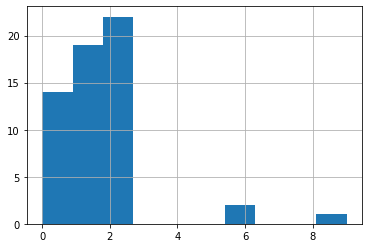

In [20]:
print("Histograma de diferencia relativa entre cantidad despachada y la capacidad ed tanque")
transa_sospechosas.dif_rel.hist()

Hay transaccione que exeden por mucho la capadidad del tanque. Podemos dejar las transaccione que se exeden no mas de 10% la capacidad como una tolerancia debido a deformaciones en el tanque. El resto de las transacciones deben ser eliminadas por espureas, puede deberse a u proceso de calibracion y testing.

In [21]:
# Borro las transacciones que marque como invalidas
transacciones_df = transacciones_df.drop(transa_sospechosas[transa_sospechosas.dif_rel > 0.1].index)

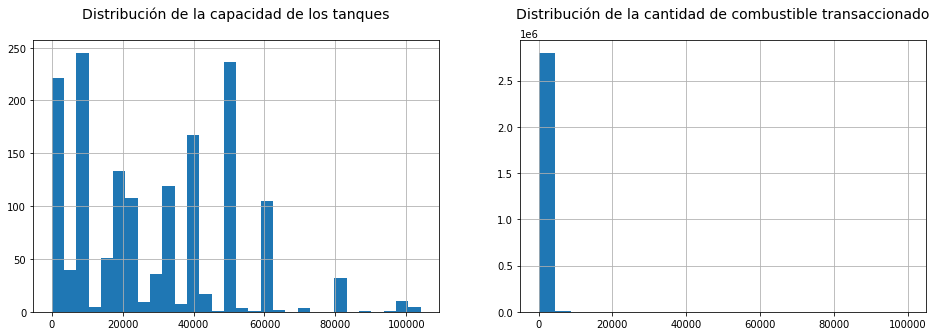

In [22]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(16,5))
tanques_df.capacidad.hist(bins=30, ax=axs[0]), 
axs[0].set_title('Distribución de la capacidad de los tanques\n', fontsize=14)
transacciones_df.cantidad.hist(bins='sturges', ax=axs[1])
axs[1].set_title('Distribución de la cantidad de combustible transaccionado\n', fontsize=14)
plt.show()

In [23]:
transacciones_df.segmento.value_counts()

Estaciones de Servicio    1006575
Transporte                 809392
Oil and Gas                254178
Constructoras              226635
Agro                       207206
Industria                  159422
Demo                        85519
Mineria                     48663
Telcos                       7487
Name: segmento, dtype: int64

In [24]:
# Columnas seleccionadas 
columns_sel = ['nombre_producto', 'fecha_hora', 'cantidad', 'segmento','main_id']
data = transacciones_df[columns_sel]
data = data.sort_values('fecha_hora', ascending=True)
data.head()

nombre_producto          fecha_hora    cantidad    segmento main_id
4             DIESEL 2018-01-01 00:23:00  360.018005  Transporte  000355
60            DIESEL 2018-01-01 01:40:00   71.621002  Transporte  000300
61            DIESEL 2018-01-01 01:45:00   35.368000  Transporte  000149
1429     DESCONOCIDO 2018-01-01 02:05:00  600.046997  Transporte  000007
5             DIESEL 2018-01-01 02:28:00  190.229996  Transporte  000356

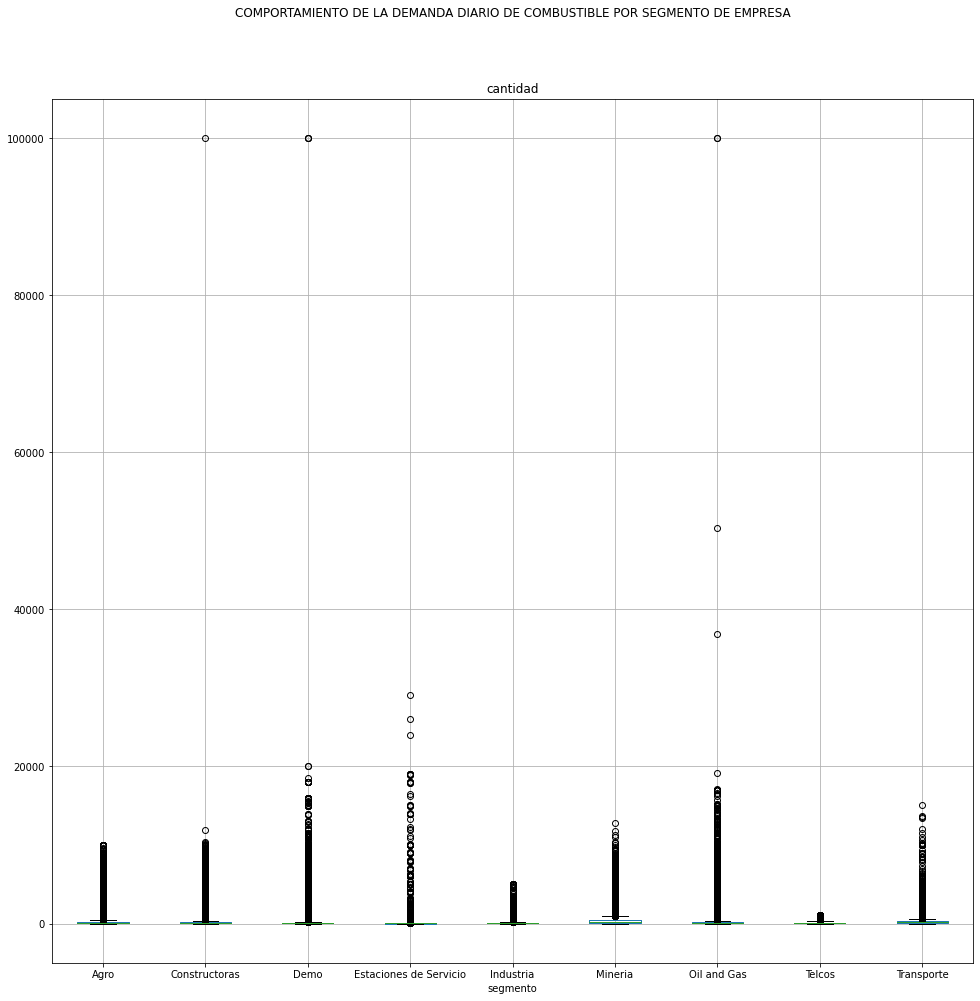

In [25]:
transacciones_df.boxplot(column='cantidad', by='segmento', figsize=(16,16))
plt.suptitle('COMPORTAMIENTO DE LA DEMANDA DIARIO DE COMBUSTIBLE POR SEGMENTO DE EMPRESA')
plt.show()

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2805077 entries, 4 to 1566202
Data columns (total 5 columns):
 #   Column           Dtype         
---  ------           -----         
 0   nombre_producto  object        
 1   fecha_hora       datetime64[ns]
 2   cantidad         float32       
 3   segmento         object        
 4   main_id          object        
dtypes: datetime64[ns](1), float32(1), object(3)
memory usage: 117.7+ MB


In [27]:
data.isnull().sum()/len(data)*100

nombre_producto    0.00000
fecha_hora         0.00000
cantidad           0.00000
segmento           0.00000
main_id            9.56398
dtype: float64

In [28]:
# Conversión de variables categóricas
var_categorical = ['nombre_producto', 'segmento']
data[var_categorical] = data[var_categorical].apply(lambda x: x.astype('category'))
data.dtypes

nombre_producto          category
fecha_hora         datetime64[ns]
cantidad                  float32
segmento                 category
main_id                    object
dtype: object

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print("Existen transacciones de :" + str(data.nombre_producto.unique().categories))

Existen transacciones de :Index(['DIESEL', 'DESCONOCIDO', 'NAFTA', 'FORMULA', 'COMBUSTIBLE',
       'INFINIA T40', 'INFINIA T20', 'AVGAS 100', 'UREA', 'COMUN', 'BIO',
       'INFINIA', 'GENÉRICO', 'ACEITE', 'REFRIGERANTE', 'GRASA'],
      dtype='object')


In [30]:
# Veo cuales productos no etiquetados como diesel corresponden a diesel
data[data.nombre_producto.isin(['COMBUSTIBLE','FORMULA','COMUN','INFINIA T20','INFINIA T40', 'INFINIA','GENERICO'])].segmento.unique()

[Oil and Gas, Transporte, Constructoras, Agro]
Categories (4, object): [Oil and Gas, Transporte, Constructoras, Agro]

Por el segmento al que pertenecen las empresas que pusieron estas etiquetas, sabemos que solo consumen Diesel por ende estas etiquetas tambien corresponden a Diesel.

In [31]:
# Dejo solo los productos que me interesa utilizar. Ademas elimino el segmento Demo porque son datos espureos
productos_interesantes = ['DIESEL','FORMULA', 'BIO', 'COMBUSTIBLE','FORMULA','COMUN','INFINIA T20','INFINIA T40', 'INFINIA','GENERICO']
filtered_data = data[data.nombre_producto.isin(productos_interesantes) & (data.segmento != 'Demo')]
filtered_data

nombre_producto          fecha_hora    cantidad       segmento main_id
4                DIESEL 2018-01-01 00:23:00  360.018005     Transporte  000355
60               DIESEL 2018-01-01 01:40:00   71.621002     Transporte  000300
61               DIESEL 2018-01-01 01:45:00   35.368000     Transporte  000149
5                DIESEL 2018-01-01 02:28:00  190.229996     Transporte  000356
1015             DIESEL 2018-01-01 06:44:00  143.035995  Constructoras  001143
...                 ...                 ...         ...            ...     ...
1565988          DIESEL 2020-05-31 23:20:06   66.032997           Agro  000574
1566010          DIESEL 2020-05-31 23:22:04  352.144989     Transporte  003016
1566001          DIESEL 2020-05-31 23:27:15  278.847992           Agro  002079
1566009          DIESEL 2020-05-31 23:30:00   68.708000  Constructoras  000174
1566011          DIESEL 2020-05-31 23:33:31   69.608002      Industria  001206

[1085260 rows x 5 columns]

In [32]:
# Downsampling de transacciones. Agrupando por segmento y por producto
dicc_operations = {
                   'cantidad': 'sum',
                    'main_id': lambda x: len(x.unique())
                  }

# Obtención de la data peródica
data_period = pd.DataFrame()
for segment, product in filtered_data.groupby(['segmento','nombre_producto']).count().index:
    resampled = filtered_data[(filtered_data.segmento==segment) & (filtered_data.nombre_producto == product)]\
        .set_index('fecha_hora').resample('1D').agg(dicc_operations).reset_index()
    resampled['segmento']=segment
    resampled['producto']=product
    data_period = data_period.append(resampled) #.apply(logic)
data_period = data_period.sort_values('fecha_hora').reset_index()
data_period.rename(columns={'main_id':'cantidad_vehiculos'}, inplace=True )
data_period.head()

index fecha_hora      cantidad  cantidad_vehiculos                segmento  \
0      0 2018-01-01   1273.491943                 1.0  Estaciones de Servicio   
1      0 2018-01-01  10308.130859                 4.0             Oil and Gas   
2      0 2018-01-01    821.515015                 6.0           Constructoras   
3      0 2018-01-01     62.575001                 1.0               Industria   
4      0 2018-01-01  19902.337891               129.0              Transporte   

  producto  
0   DIESEL  
1   DIESEL  
2   DIESEL  
3   DIESEL  
4   DIESEL

In [33]:
data_period.segmento.unique()

array(['Estaciones de Servicio', 'Oil and Gas', 'Constructoras',
       'Industria', 'Transporte', 'Agro', 'Mineria', 'Telcos'],
      dtype=object)

In [34]:
# Agrupo los productos para tratarlos como uno solo.
dicc_operations = {
                   'cantidad': 'sum',
                    'cantidad_vehiculos': 'sum'
                  }
data_period = data_period.groupby(['segmento', 'fecha_hora']).agg(dicc_operations).reset_index(drop=False).sort_values('fecha_hora')

In [35]:
data_period.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 0 to 6257
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   segmento            6258 non-null   object        
 1   fecha_hora          6258 non-null   datetime64[ns]
 2   cantidad            6258 non-null   float32       
 3   cantidad_vehiculos  6258 non-null   float64       
dtypes: datetime64[ns](1), float32(1), float64(1), object(1)
memory usage: 220.0+ KB


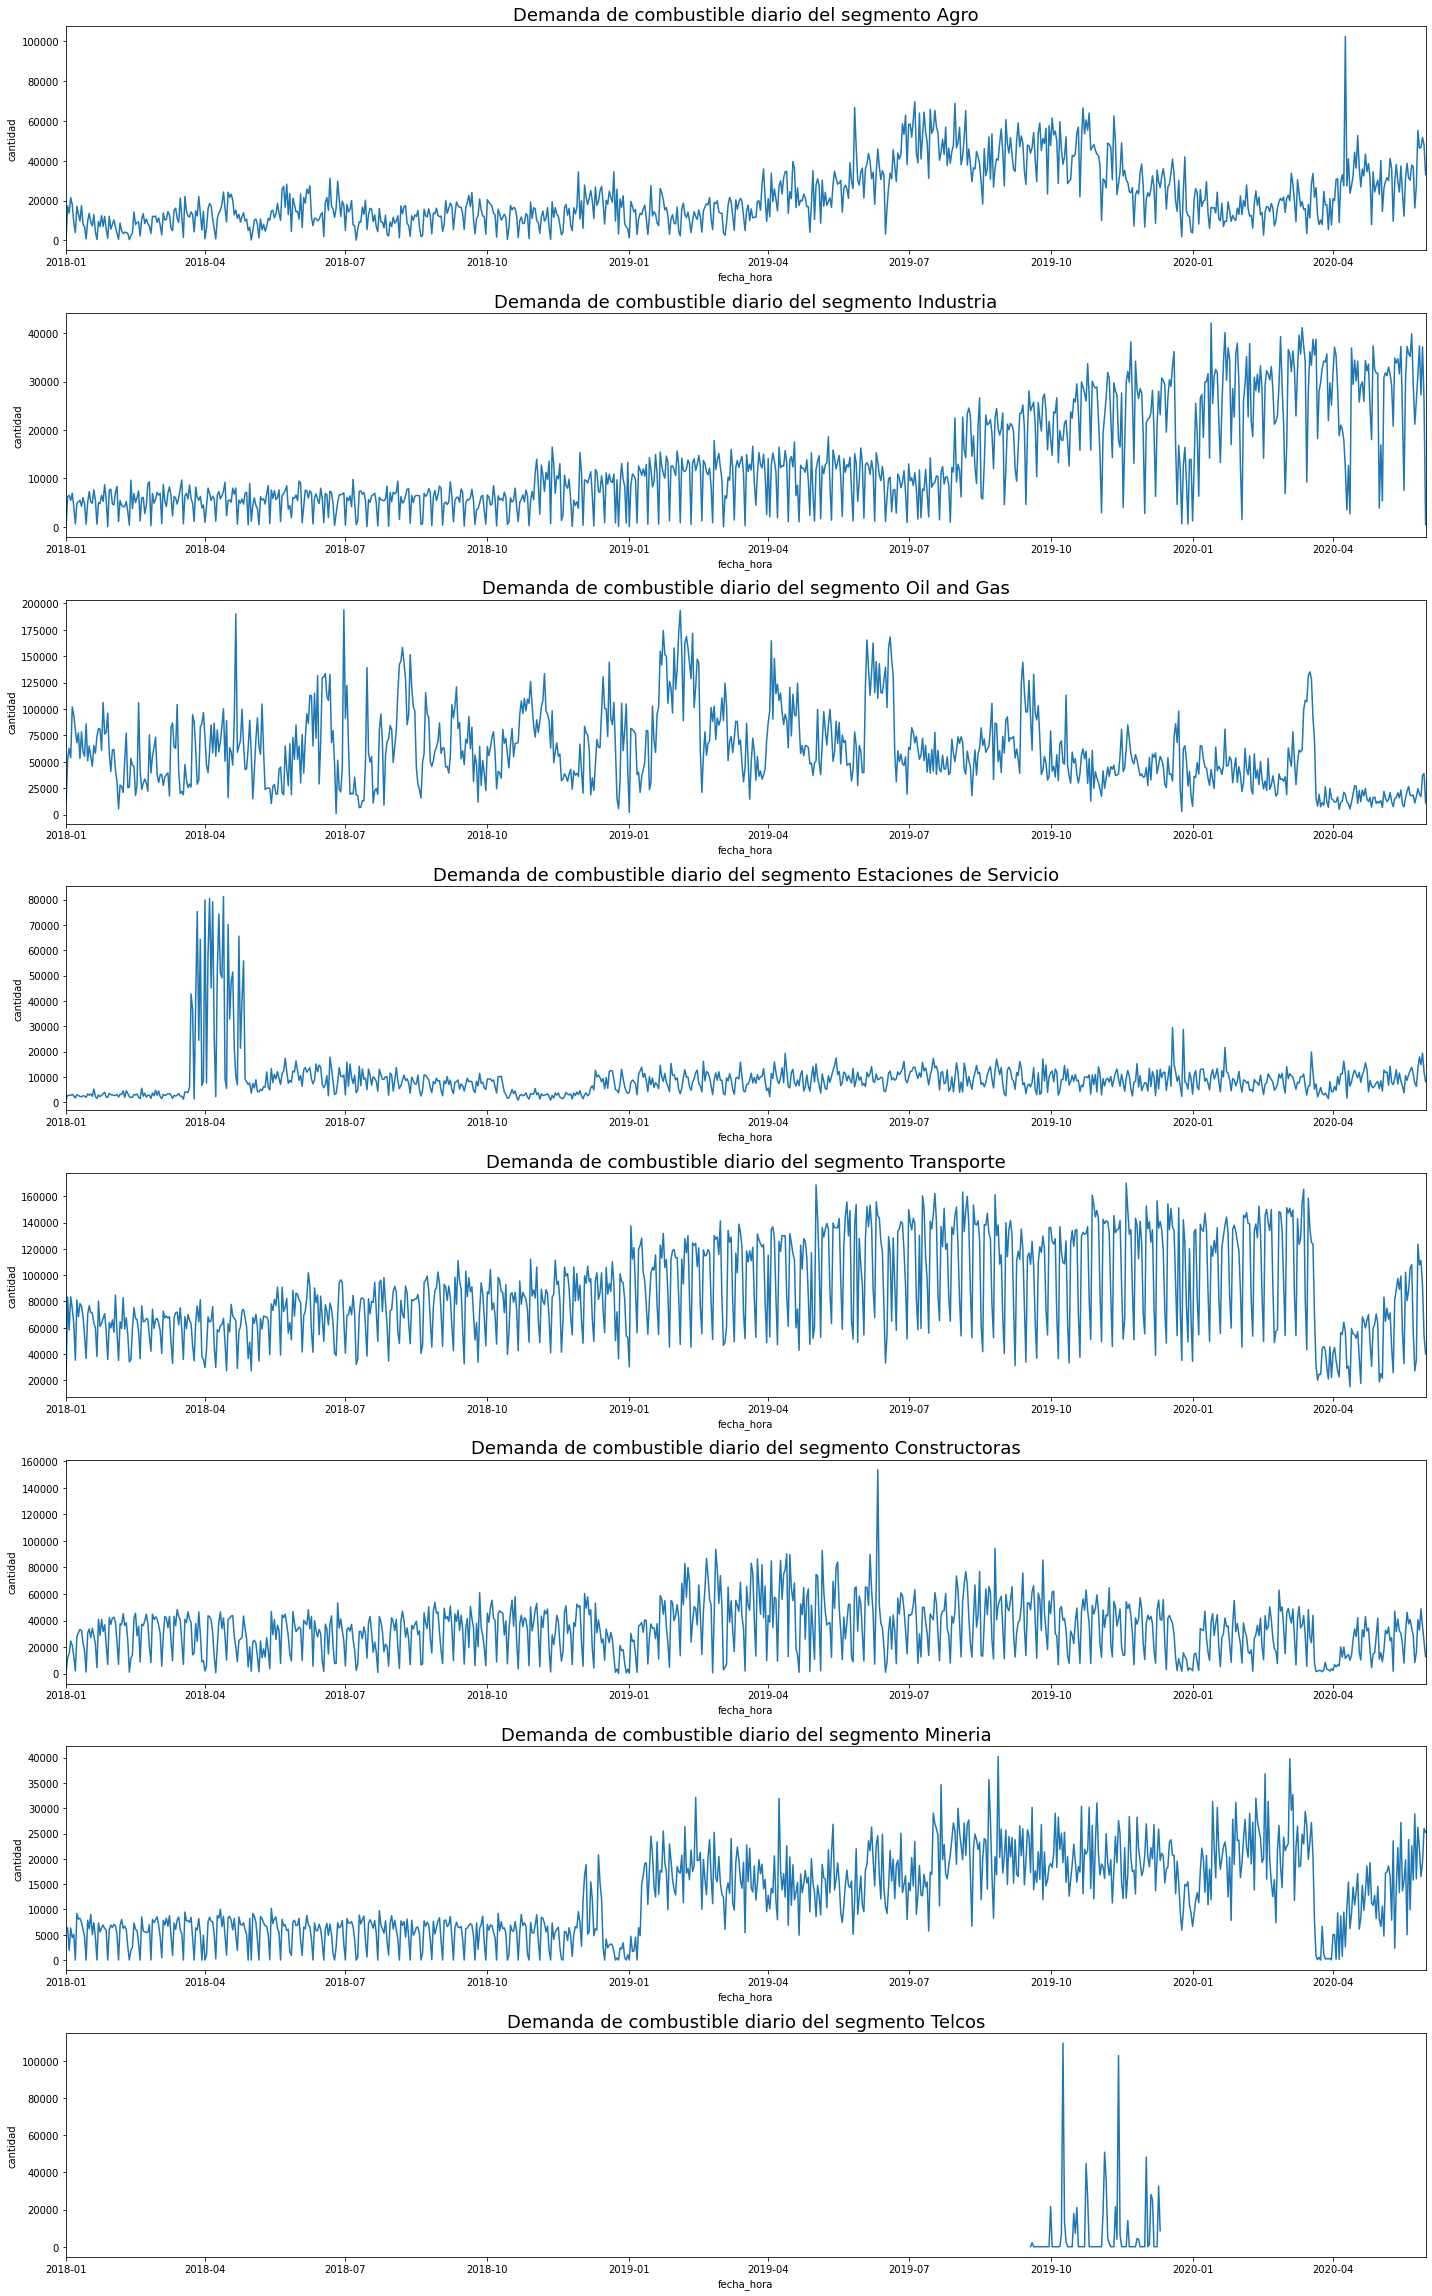

In [36]:
#fig = plt.figure(figsize=(19,4*8))

dt_min, dt_max = data_period.fecha_hora.min(), data_period.fecha_hora.max()

cols_count = len(data_period.segmento.unique())
fig,sps = plt.subplots(cols_count,)
fig.set_size_inches(20, 4*8, forward=True)

for i, segment in enumerate(data_period.segmento.unique()):
    sps[i].set_title("Demanda de combustible diario del segmento {}".format(segment), fontdict={'fontsize':18})
    ax = sns.lineplot(data=data_period[data_period.segmento == segment],x='fecha_hora', y='cantidad',  ax=sps[i])
    ax.set_xlim(dt_min, dt_max)
    

fig.tight_layout()


Vemos que hay un pico muy grande en las estaciones de servicio alrededor de abril de 2018. Por otro lado vemos que telcos no aporta mucho ni es un segmento importante para predecir.

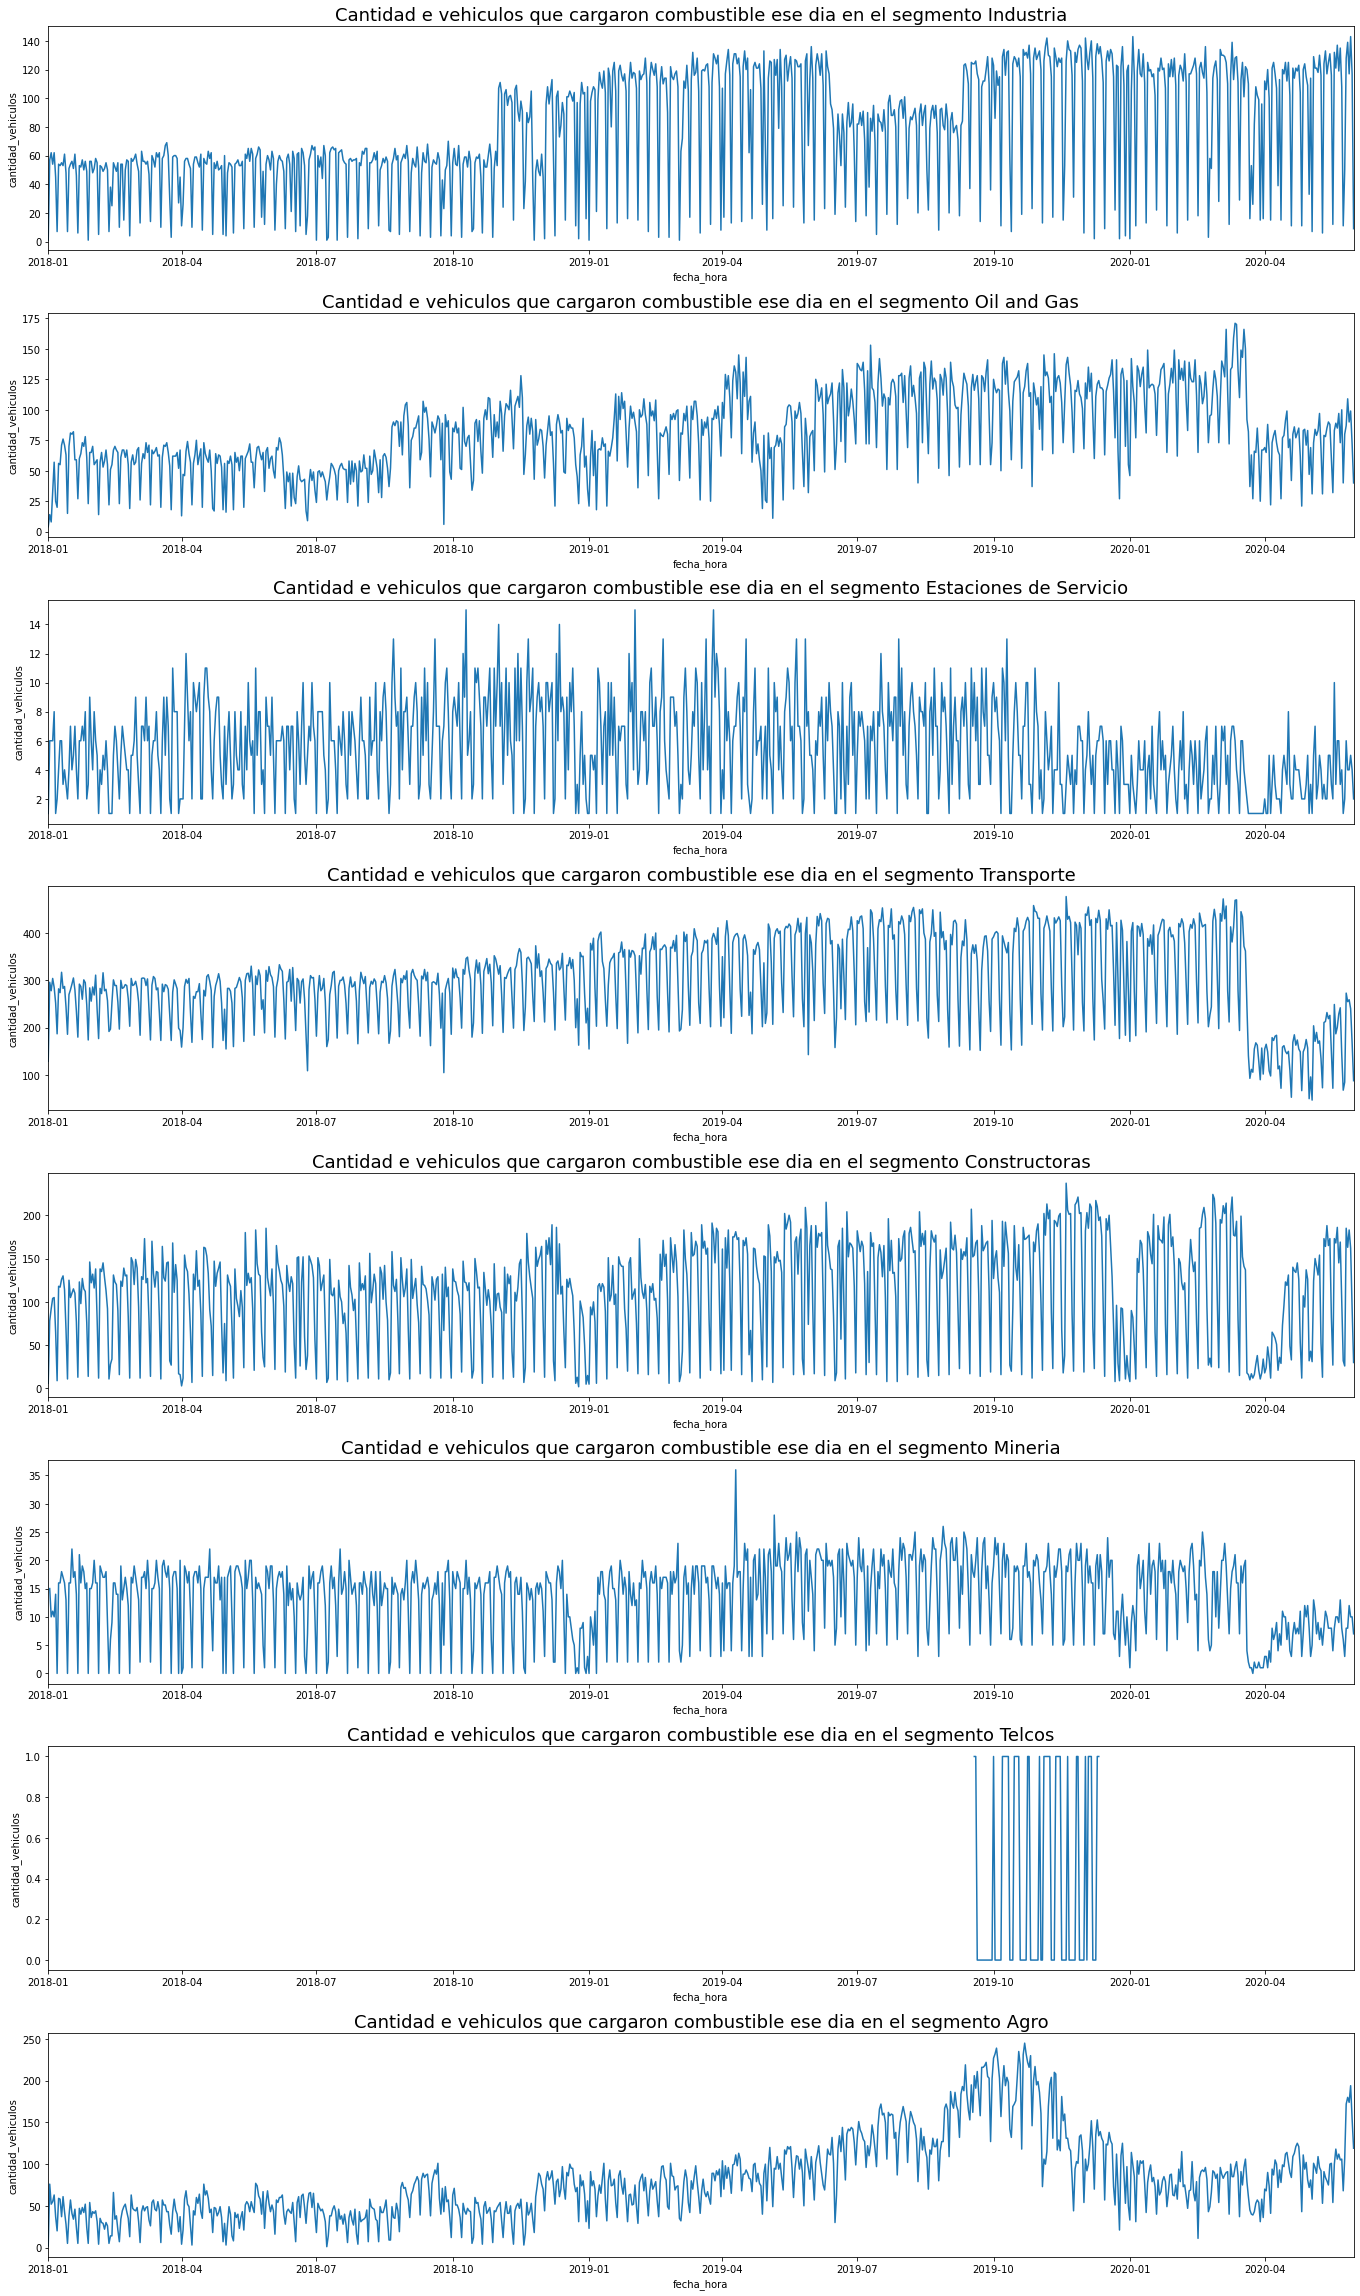

In [37]:
# GRafico la cantidad de vehiculos agrupados en el dia por segmento
fig = plt.figure(figsize=(19,4*8))

dt_min, dt_max = data_period.fecha_hora.min(), data_period.fecha_hora.max()

cols_count = len(data_period.segmento.unique())
for i, segment in enumerate(data_period.segmento.unique()):
    sp = plt.subplot(str(cols_count*100+10+i))
    sp.set_title("Cantidad e vehiculos que cargaron combustible ese dia en el segmento {}".format(segment), fontdict={'fontsize':18})
    ax = sns.lineplot(data=data_period[data_period.segmento == segment],x='fecha_hora', y='cantidad_vehiculos',  ax=sp)

    ax.set_xlim(dt_min, dt_max)

fig.tight_layout()

https://machinelearningmastery.com/basic-feature-engineering-time-series-data-python/

In [38]:
# Algunas features extras que se pueden obtener a partir del mes y año
# Extracción de mes y año
data_period['year'] = data_period['fecha_hora'].dt.year
data_period['month'] = data_period['fecha_hora'].dt.month
data_period['weekofyear'] = data_period['fecha_hora'].dt.weekofyear
data_period['weekday'] = data_period['fecha_hora'].dt.weekday
data_period['quarter'] = data_period['fecha_hora'].dt.quarter
data_period['is_quarter_start'] = data_period['fecha_hora'].dt.is_quarter_start
data_period['is_quarter_end'] = data_period['fecha_hora'].dt.is_quarter_end

# Otras features para considerar en otros periodos de tiempo
data_period['day'] = data_period['fecha_hora'].dt.day
data_period['dayofyear'] = data_period['fecha_hora'].dt.dayofyear
#data_period['dayofweek'] = data_period['fecha_hora'].dt.dayofweek
data_period['is_month_start'] = data_period['fecha_hora'].dt.is_month_start
data_period['is_month_end'] = data_period['fecha_hora'].dt.is_month_end
# data_period['is_year_start'] = data_period['fecha_hora'].dt.is_year_start
# data_period['is_year_end'] = data_period['fecha_hora'].dt.is_year_end

In [39]:
# Creación de medias móviles de 3 y 6 periodos por segmento
data_period['sma3'] = np.nan
data_period['sma6'] = np.nan

for i, segment in enumerate(data_period.segmento.unique()):
    data_p = data_period[data_period.segmento == segment]
    data_period.at[data_p.index,'sma3'] = data_p.cantidad.rolling(3).mean().fillna(method='backfill')
    data_period.at[data_p.index,'sma6'] = data_p.cantidad.rolling(6).mean().fillna(method='backfill')


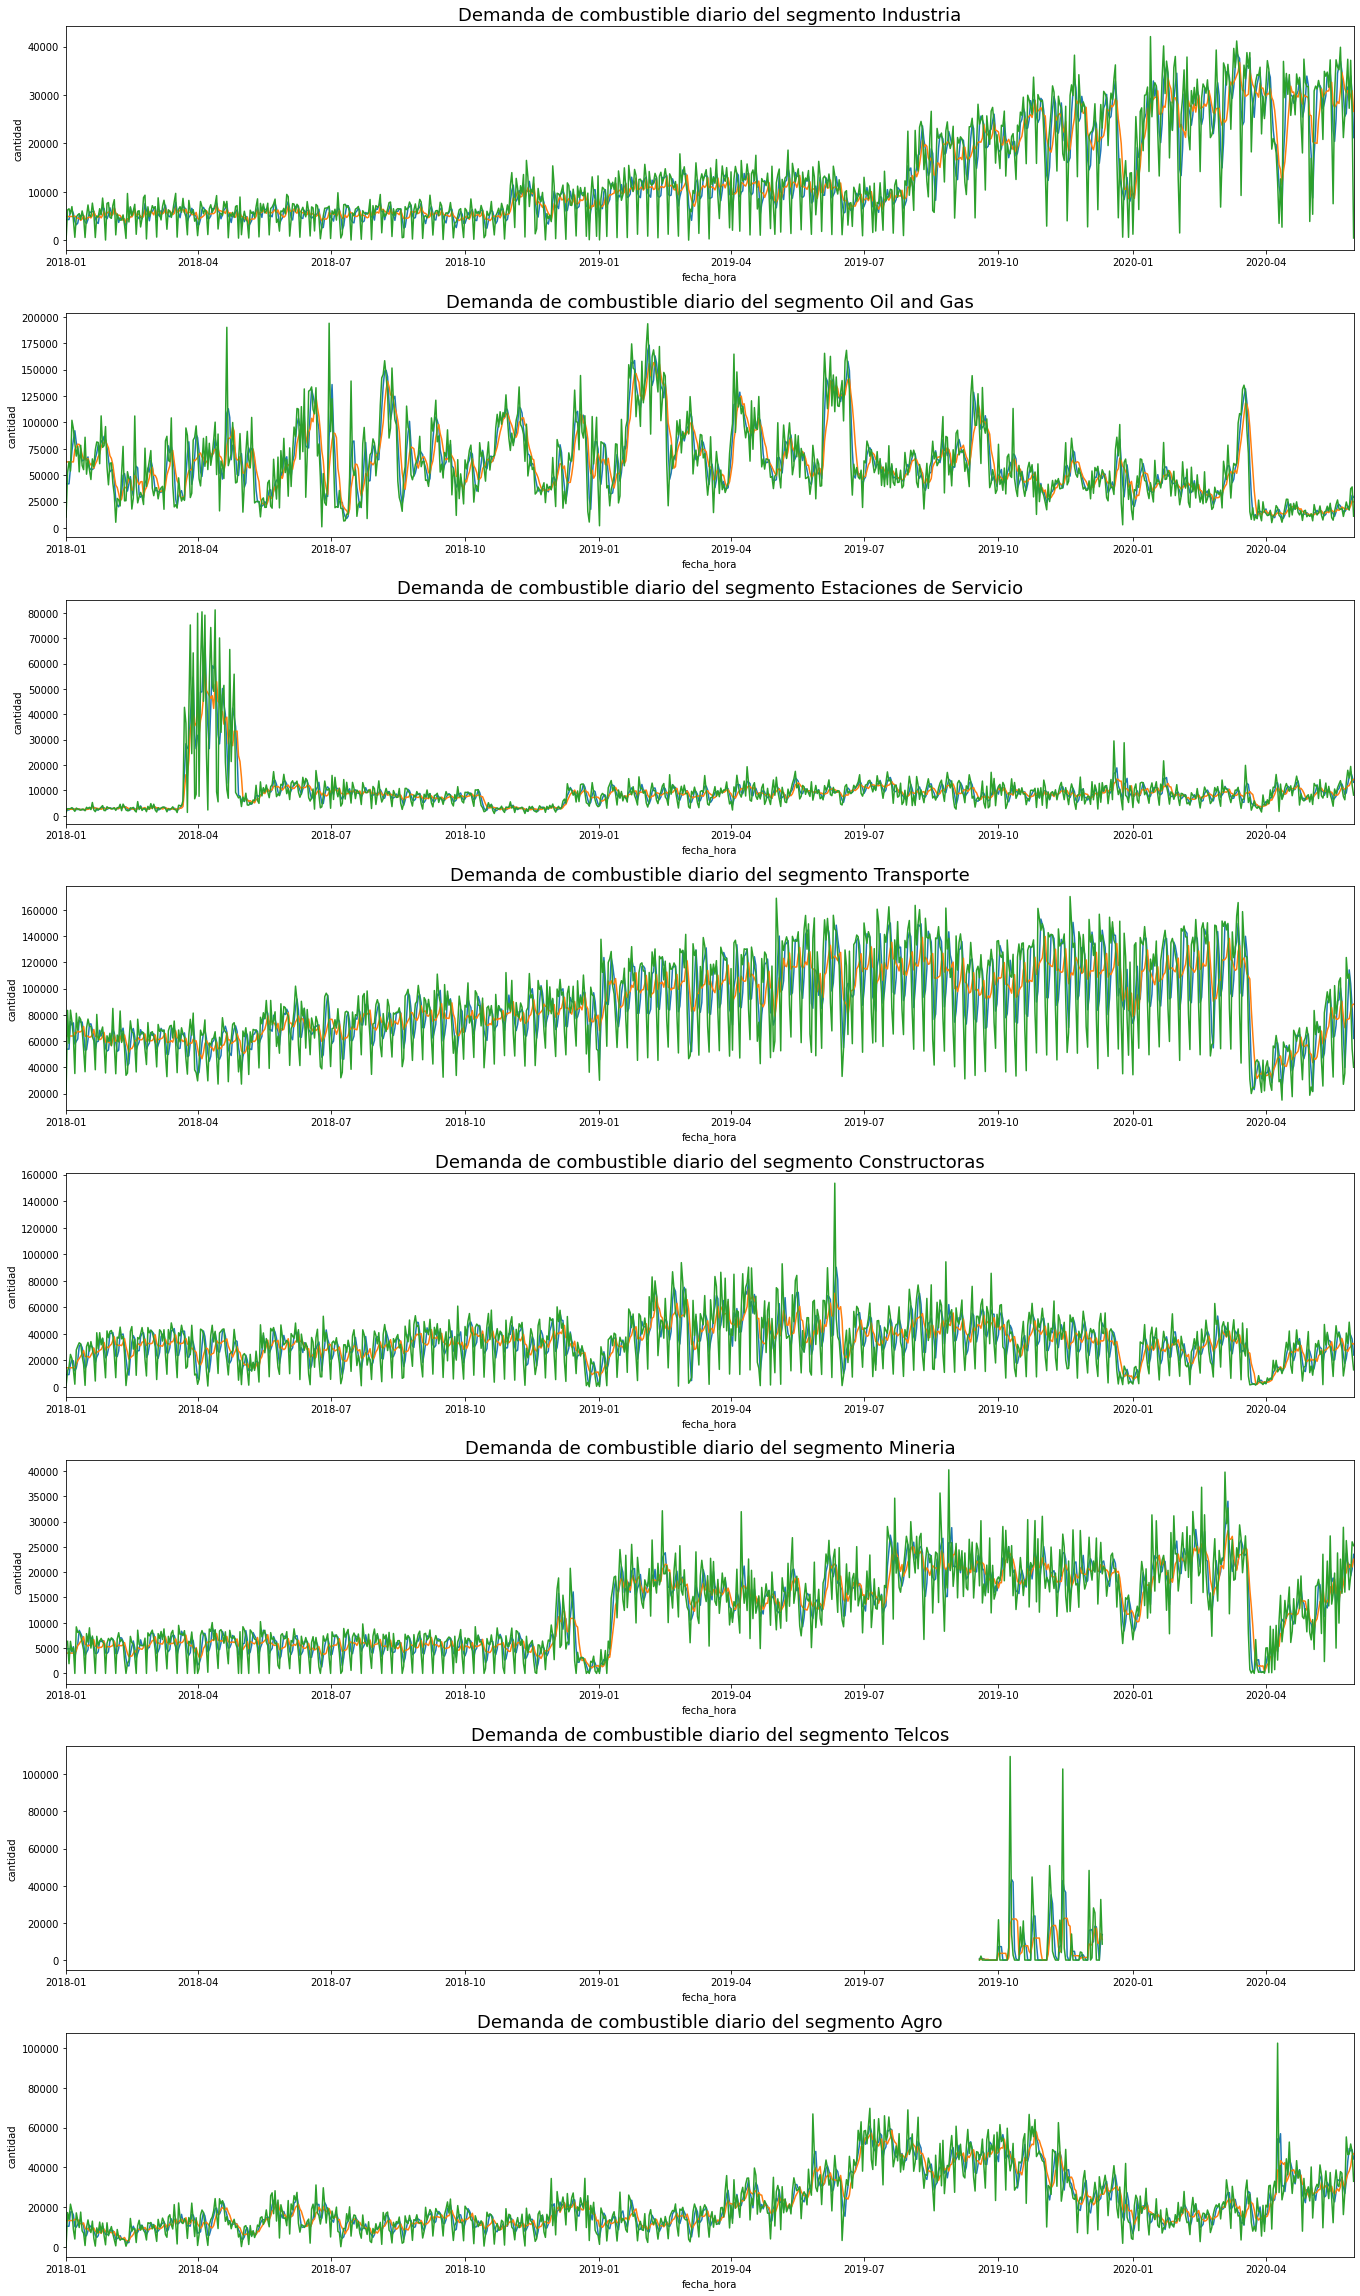

In [40]:
fig = plt.figure(figsize=(19,4*8))

dt_min, dt_max = data_period.fecha_hora.min(), data_period.fecha_hora.max()

cols_count = len(data_period.segmento.unique())
for i, segment in enumerate(data_period.segmento.unique()):
    sp = plt.subplot(str(cols_count*100+10+i))
    sp.set_title("Demanda de combustible diario del segmento {}".format(segment), fontdict={'fontsize':18})
    ax = sns.lineplot(data=data_period[data_period.segmento == segment],x='fecha_hora', y='sma3', ci=None, ax=sp)
    ax = sns.lineplot(data=data_period[data_period.segmento == segment],x='fecha_hora', y='sma6', ci=None, ax=sp)
    ax = sns.lineplot(data=data_period[data_period.segmento == segment],x='fecha_hora', y='cantidad', ci=None, ax=sp)
    
    ax.set_xlim(dt_min, dt_max)

fig.tight_layout()


In [41]:
data_period.head()

segmento fecha_hora      cantidad  cantidad_vehiculos  \
0                       Agro 2018-01-01    125.188004                 2.0   
2646               Industria 2018-01-01     62.575001                 1.0   
4409             Oil and Gas 2018-01-01  10308.130859                 4.0   
1764  Estaciones de Servicio 2018-01-01   1273.491943                 1.0   
5376              Transporte 2018-01-01  19902.337891               129.0   

      year  month  weekofyear  weekday  quarter  is_quarter_start  \
0     2018      1           1        0        1              True   
2646  2018      1           1        0        1              True   
4409  2018      1           1        0        1              True   
1764  2018      1           1        0        1              True   
5376  2018      1           1        0        1              True   

      is_quarter_end  day  dayofyear  is_month_start  is_month_end  \
0              False    1          1            True         False   
2646           False    1          1            True         False   
4409           False    1          1            True         False   
1764           False    1          1            True         False   
5376           False    1          1            True         False   

              sma3          sma6  
0     10360.225428  13218.230227  
2646   4269.728451   4897.214486  
4409  41760.285807  62502.973633  
1764   2267.479980   2547.213298  
5376  53852.447266  63855.713867

In [42]:
data_period.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 0 to 6257
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   segmento            6258 non-null   object        
 1   fecha_hora          6258 non-null   datetime64[ns]
 2   cantidad            6258 non-null   float32       
 3   cantidad_vehiculos  6258 non-null   float64       
 4   year                6258 non-null   int64         
 5   month               6258 non-null   int64         
 6   weekofyear          6258 non-null   int64         
 7   weekday             6258 non-null   int64         
 8   quarter             6258 non-null   int64         
 9   is_quarter_start    6258 non-null   bool          
 10  is_quarter_end      6258 non-null   bool          
 11  day                 6258 non-null   int64         
 12  dayofyear           6258 non-null   int64         
 13  is_month_start      6258 non-null   bool        

In [43]:
# Transformación de valores booleanos (codificación)
var_boolean = data_period.select_dtypes(include='bool').columns
data_period[var_boolean] = data_period[var_boolean].apply(lambda x: x.astype('category').cat.codes)
# Conversiones de variables categóricas
var_categorical = ['segmento']
data_period[var_categorical] = data_period[var_categorical].apply(lambda x: x.astype('category'))
data_period.head()

segmento fecha_hora      cantidad  cantidad_vehiculos  \
0                       Agro 2018-01-01    125.188004                 2.0   
2646               Industria 2018-01-01     62.575001                 1.0   
4409             Oil and Gas 2018-01-01  10308.130859                 4.0   
1764  Estaciones de Servicio 2018-01-01   1273.491943                 1.0   
5376              Transporte 2018-01-01  19902.337891               129.0   

      year  month  weekofyear  weekday  quarter  is_quarter_start  \
0     2018      1           1        0        1                 1   
2646  2018      1           1        0        1                 1   
4409  2018      1           1        0        1                 1   
1764  2018      1           1        0        1                 1   
5376  2018      1           1        0        1                 1   

      is_quarter_end  day  dayofyear  is_month_start  is_month_end  \
0                  0    1          1               1             0   
2646               0    1          1               1             0   
4409               0    1          1               1             0   
1764               0    1          1               1             0   
5376               0    1          1               1             0   

              sma3          sma6  
0     10360.225428  13218.230227  
2646   4269.728451   4897.214486  
4409  41760.285807  62502.973633  
1764   2267.479980   2547.213298  
5376  53852.447266  63855.713867

In [44]:
# Creación de otros features
for i, segment in enumerate(data_period.segmento.unique()):
    data_p = data_period[data_period.segmento == segment]
    data_period.at[data_p.index,'pct_change'] = data_p['cantidad'].pct_change().fillna(0)
    data_period.at[data_p.index,'pct_change_week'] = data_p['cantidad'].pct_change(periods=7).fillna(0)

data_period

segmento fecha_hora      cantidad  cantidad_vehiculos  \
0                       Agro 2018-01-01    125.188004                 2.0   
2646               Industria 2018-01-01     62.575001                 1.0   
4409             Oil and Gas 2018-01-01  10308.130859                 4.0   
1764  Estaciones de Servicio 2018-01-01   1273.491943                 1.0   
5376              Transporte 2018-01-01  19902.337891               129.0   
...                      ...        ...           ...                 ...   
1763           Constructoras 2020-05-31  12894.949219                30.0   
881                     Agro 2020-05-31  32950.675781               119.0   
4408                 Mineria 2020-05-31  25239.916016                 7.0   
5290             Oil and Gas 2020-05-31  11073.582031                40.0   
6257              Transporte 2020-05-31  40050.519531                88.0   

      year  month  weekofyear  weekday  quarter  is_quarter_start  \
0     2018      1           1        0        1                 1   
2646  2018      1           1        0        1                 1   
4409  2018      1           1        0        1                 1   
1764  2018      1           1        0        1                 1   
5376  2018      1           1        0        1                 1   
...    ...    ...         ...      ...      ...               ...   
1763  2020      5          22        6        2                 0   
881   2020      5          22        6        2                 0   
4408  2020      5          22        6        2                 0   
5290  2020      5          22        6        2                 0   
6257  2020      5          22        6        2                 0   

      is_quarter_end  day  dayofyear  is_month_start  is_month_end  \
0                  0    1          1               1             0   
2646               0    1          1               1             0   
4409               0    1          1               1             0   
1764               0    1          1               1             0   
5376               0    1          1               1             0   
...              ...  ...        ...             ...           ...   
1763               0   31        152               0             1   
881                0   31        152               0             1   
4408               0   31        152               0             1   
5290               0   31        152               0             1   
6257               0   31        152               0             1   

              sma3          sma6  pct_change  pct_change_week  
0     10360.225428  13218.230227    0.000000         0.000000  
2646   4269.728451   4897.214486    0.000000         0.000000  
4409  41760.285807  62502.973633    0.000000         0.000000  
1764   2267.479980   2547.213298    0.000000         0.000000  
5376  53852.447266  63855.713867    0.000000         0.000000  
...            ...           ...         ...              ...  
1763  24045.412109  32408.260091   -0.458956         0.557169  
881   44208.500000  46824.290365   -0.312804         1.032706  
4408  23520.279948  22549.081706   -0.029095        -0.125780  
5290  29011.205729  24640.890625   -0.714948         0.017974  
6257  62015.583333  88106.697917   -0.257985         0.479705  

[6258 rows x 19 columns]

In [45]:
# Creación de otros features
N_LAGS=7

for i, segment in enumerate(data_period.segmento.unique()):
    data_p = data_period[data_period.segmento == segment]
    for i in range(1, N_LAGS+1):
        col = 'lag_' + str(i)
        data_period.at[data_p.index,col] = data_p['cantidad'].shift(i).fillna(method='backfill')

# Con la creación de estos features se generan algunos valores nulos, imputemos dichos valores. ¿Es correcta está imputación? ¿Cuál usarías?
for i, segment in enumerate(data_period.segmento.unique()):
    data_p = data_period[data_period.segmento == segment]
    data_period.at[data_p.index,'cantidad_vehiculos_lag_7'] = data_p['cantidad_vehiculos'].shift(7).fillna(method='backfill')

print(data_period.info())
data_period.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6258 entries, 0 to 6257
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   segmento                  6258 non-null   category      
 1   fecha_hora                6258 non-null   datetime64[ns]
 2   cantidad                  6258 non-null   float32       
 3   cantidad_vehiculos        6258 non-null   float64       
 4   year                      6258 non-null   int64         
 5   month                     6258 non-null   int64         
 6   weekofyear                6258 non-null   int64         
 7   weekday                   6258 non-null   int64         
 8   quarter                   6258 non-null   int64         
 9   is_quarter_start          6258 non-null   int8          
 10  is_quarter_end            6258 non-null   int8          
 11  day                       6258 non-null   int64         
 12  dayofyear           

segmento fecha_hora      cantidad  cantidad_vehiculos  \
0                       Agro 2018-01-01    125.188004                 2.0   
2646               Industria 2018-01-01     62.575001                 1.0   
4409             Oil and Gas 2018-01-01  10308.130859                 4.0   
1764  Estaciones de Servicio 2018-01-01   1273.491943                 1.0   
5376              Transporte 2018-01-01  19902.337891               129.0   

      year  month  weekofyear  weekday  quarter  is_quarter_start  \
0     2018      1           1        0        1                 1   
2646  2018      1           1        0        1                 1   
4409  2018      1           1        0        1                 1   
1764  2018      1           1        0        1                 1   
5376  2018      1           1        0        1                 1   

      is_quarter_end  day  dayofyear  is_month_start  is_month_end  \
0                  0    1          1               1             0   
2646               0    1          1               1             0   
4409               0    1          1               1             0   
1764               0    1          1               1             0   
5376               0    1          1               1             0   

              sma3          sma6  pct_change  pct_change_week         lag_1  \
0     10360.225428  13218.230227         0.0              0.0    125.188004   
2646   4269.728451   4897.214486         0.0              0.0     62.575001   
4409  41760.285807  62502.973633         0.0              0.0  10308.130859   
1764   2267.479980   2547.213298         0.0              0.0   1273.491943   
5376  53852.447266  63855.713867         0.0              0.0  19902.337891   

             lag_2         lag_3         lag_4         lag_5         lag_6  \
0       125.188004    125.188004    125.188004    125.188004    125.188004   
2646     62.575001     62.575001     62.575001     62.575001     62.575001   
4409  10308.130859  10308.130859  10308.130859  10308.130859  10308.130859   
1764   1273.491943   1273.491943   1273.491943   1273.491943   1273.491943   
5376  19902.337891  19902.337891  19902.337891  19902.337891  19902.337891   

             lag_7  cantidad_vehiculos_lag_7  
0       125.188004                       2.0  
2646     62.575001                       1.0  
4409  10308.130859                       4.0  
1764   1273.491943                       1.0  
5376  19902.337891                     129.0

In [46]:
data_period.describe()

cantidad  cantidad_vehiculos         year        month  \
count    6258.000000         6258.000000  6258.000000  6258.000000   
mean    34065.136719           95.155002  2018.761905     5.981943   
std     35474.601562          103.383145     0.722173     3.475409   
min         0.000000            0.000000  2018.000000     1.000000   
25%      8491.640381           15.000000  2018.000000     3.000000   
50%     19985.200195           65.000000  2019.000000     5.000000   
75%     47912.118164          128.000000  2019.000000     9.000000   
max    193830.125000          477.000000  2020.000000    12.000000   

        weekofyear     weekday      quarter  is_quarter_start  is_quarter_end  \
count  6258.000000  6258.00000  6258.000000       6258.000000     6258.000000   
mean     24.155960     3.00032     2.339565          0.011186        0.010227   
std      15.093591     1.99984     1.124745          0.105178        0.100618   
min       1.000000     0.00000     1.000000          0.000000        0.000000   
25%      11.000000     1.00000     1.000000          0.000000        0.000000   
50%      22.000000     3.00000     2.000000          0.000000        0.000000   
75%      37.000000     5.00000     3.000000          0.000000        0.000000   
max      52.000000     6.00000     4.000000          1.000000        1.000000   

               day    dayofyear  is_month_start  is_month_end           sma3  \
count  6258.000000  6258.000000     6258.000000   6258.000000    6258.000000   
mean     15.721636   166.551614        0.032758      0.032918   34063.480570   
std       8.797866   106.070189        0.178017      0.178436   33343.948839   
min       1.000000     1.000000        0.000000      0.000000       0.000000   
25%       8.000000    75.000000        0.000000      0.000000    9254.011866   
50%      16.000000   150.000000        0.000000      0.000000   21198.122396   
75%      23.000000   260.000000        0.000000      0.000000   48336.953613   
max      31.000000   365.000000        1.000000      1.000000  173076.687500   

                sma6   pct_change  pct_change_week          lag_1  \
count    6258.000000  6258.000000      6258.000000    6258.000000   
mean    34051.384812          inf              inf   34049.072023   
std     32329.027138          NaN              NaN   35482.789187   
min         0.000000    -1.000000        -1.000000       0.000000   
25%      9429.783335    -0.286260        -0.201403    8477.636475   
50%     21424.045492    -0.029531         0.000000   19959.573242   
75%     48730.475423     0.289767         0.283209   47912.118164   
max    156488.998698          inf              inf  193830.125000   

               lag_2          lag_3          lag_4          lag_5  \
count    6258.000000    6258.000000    6258.000000    6258.000000   
mean    34013.537302   33973.050025   33934.161724   33895.037362   
std     35495.921347   35500.114872   35497.041468   35496.414089   
min         0.000000       0.000000       0.000000       0.000000   
25%      8447.214111    8431.154541    8402.367432    8374.489746   
50%     19899.806641   19883.579102   19869.379883   19843.724609   
75%     47866.704102   47848.080078   47777.442383   47757.204102   
max    193830.125000  193830.125000  193830.125000  193830.125000   

               lag_6          lag_7  cantidad_vehiculos_lag_7  
count    6258.000000    6258.000000               6258.000000  
mean    33846.849359   33825.551052                 94.585171  
std     35491.640096   35503.466504                103.414358  
min         0.000000       0.000000                  0.000000  
25%      8345.939941    8325.197021                 15.000000  
50%     19804.466797   19754.332031                 64.000000  
75%     47707.342773   47707.342773                127.000000  
max    193830.125000  193830.125000                477.000000

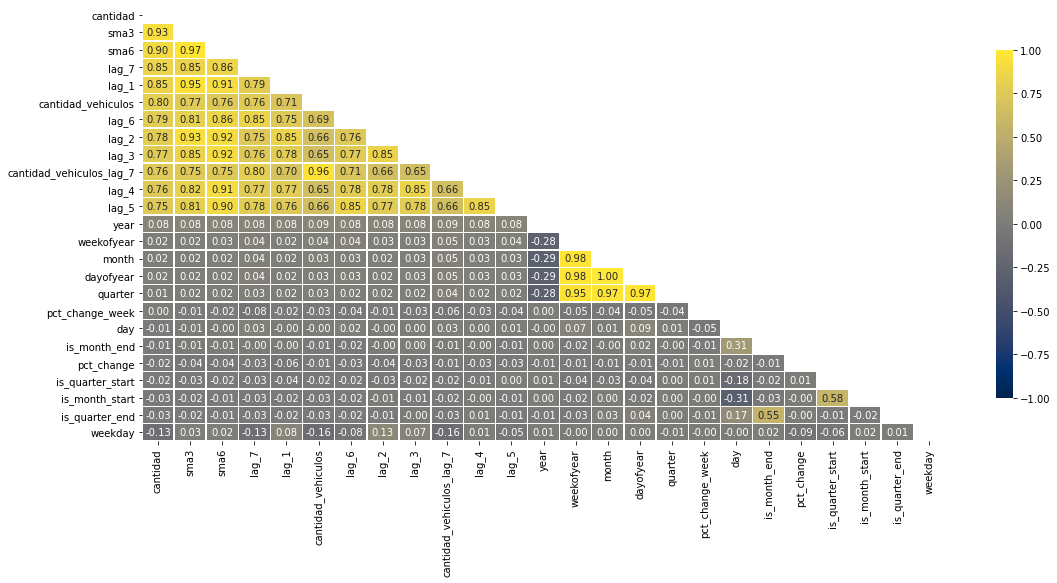

In [47]:
# Veriquemos la correlación entre las variables
correlaciones = data_period.corr().sort_values(by='cantidad', ascending=False).sort_values(by='cantidad', ascending=False, axis=1)
mask = np.zeros_like(correlaciones, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(18,8))
sns.heatmap(correlaciones, mask=mask, fmt=".2f", vmin=-1, vmax=1, center=0, annot=True, cmap='cividis', linewidths=.4, cbar_kws={"shrink": .8})
plt.show()

In [48]:
# Probar la relación entre las variables categoricas, como "is_quarter_start", "is_quarter_end", etc con "cantidad", teniendo en cuenta la naturaleza de las variables


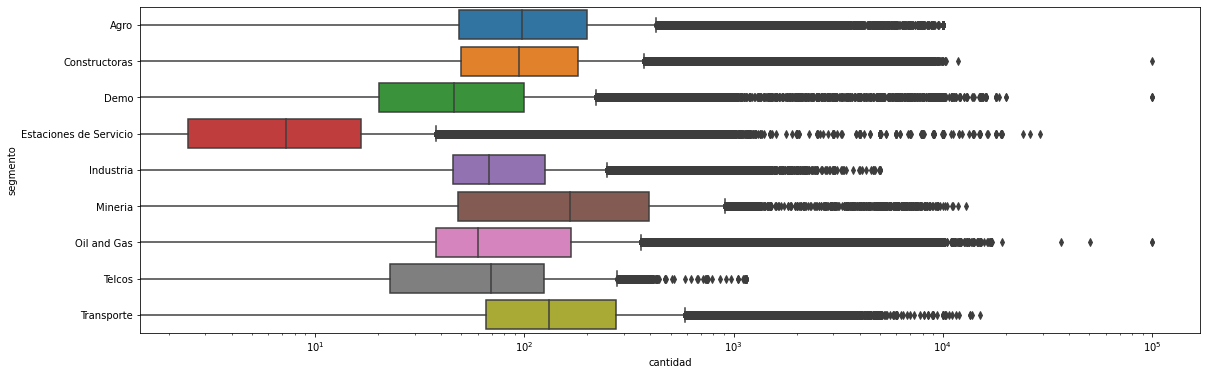

In [49]:
plt.figure(figsize=(19,6))
ax = sns.boxplot(data=data, x='cantidad', y='segmento')
ax.set(xscale='log')
#plt.boxplot(data_period['cantidad'], notch=True, showmeans=True, vert=False), plt.title('Distribución de la demanda de combustible quincenal\n')
#plt.xlabel('Demanda quincenal')
plt.show()

In [50]:
#data_period[data_period['pct_change_week'].isin([np.inf,np.nan])]
data_period['pct_change'] = np.where(data_period['pct_change'].isin([np.inf,np.nan]), data_period['pct_change_week'], data_period['pct_change'])
data_period['pct_change_week'] = np.where(data_period['pct_change_week'].isin([np.inf,np.nan]), data_period['pct_change'], data_period['pct_change_week'])

data_period['pct_change_week'] = data_period['pct_change_week'].replace(np.inf, np.nan).fillna(method='bfill')
data_period['pct_change'] = data_period['pct_change'].replace(np.inf, np.nan).fillna(method='bfill')

data_period[data_period['pct_change_week'].isin([np.inf,np.nan]) | data_period['pct_change'].isin([np.inf,np.nan])]

Empty DataFrame
Columns: [segmento, fecha_hora, cantidad, cantidad_vehiculos, year, month, weekofyear, weekday, quarter, is_quarter_start, is_quarter_end, day, dayofyear, is_month_start, is_month_end, sma3, sma6, pct_change, pct_change_week, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, cantidad_vehiculos_lag_7]
Index: []

In [51]:
# one hot encoding de segmentos
data_period.segmento = data_period.segmento.str.replace(r'\s','_')
df_train = pd.get_dummies(data=data_period, columns=['segmento'])
df_train

fecha_hora      cantidad  cantidad_vehiculos  year  month  weekofyear  \
0    2018-01-01    125.188004                 2.0  2018      1           1   
2646 2018-01-01     62.575001                 1.0  2018      1           1   
4409 2018-01-01  10308.130859                 4.0  2018      1           1   
1764 2018-01-01   1273.491943                 1.0  2018      1           1   
5376 2018-01-01  19902.337891               129.0  2018      1           1   
...         ...           ...                 ...   ...    ...         ...   
1763 2020-05-31  12894.949219                30.0  2020      5          22   
881  2020-05-31  32950.675781               119.0  2020      5          22   
4408 2020-05-31  25239.916016                 7.0  2020      5          22   
5290 2020-05-31  11073.582031                40.0  2020      5          22   
6257 2020-05-31  40050.519531                88.0  2020      5          22   

      weekday  quarter  is_quarter_start  is_quarter_end  day  dayofyear  \
0           0        1                 1               0    1          1   
2646        0        1                 1               0    1          1   
4409        0        1                 1               0    1          1   
1764        0        1                 1               0    1          1   
5376        0        1                 1               0    1          1   
...       ...      ...               ...             ...  ...        ...   
1763        6        2                 0               0   31        152   
881         6        2                 0               0   31        152   
4408        6        2                 0               0   31        152   
5290        6        2                 0               0   31        152   
6257        6        2                 0               0   31        152   

      is_month_start  is_month_end          sma3          sma6  pct_change  \
0                  1             0  10360.225428  13218.230227    0.000000   
2646               1             0   4269.728451   4897.214486    0.000000   
4409               1             0  41760.285807  62502.973633    0.000000   
1764               1             0   2267.479980   2547.213298    0.000000   
5376               1             0  53852.447266  63855.713867    0.000000   
...              ...           ...           ...           ...         ...   
1763               0             1  24045.412109  32408.260091   -0.458956   
881                0             1  44208.500000  46824.290365   -0.312804   
4408               0             1  23520.279948  22549.081706   -0.029095   
5290               0             1  29011.205729  24640.890625   -0.714948   
6257               0             1  62015.583333  88106.697917   -0.257985   

      pct_change_week         lag_1         lag_2          lag_3  \
0            0.000000    125.188004    125.188004     125.188004   
2646         0.000000     62.575001     62.575001      62.575001   
4409         0.000000  10308.130859  10308.130859   10308.130859   
1764         0.000000   1273.491943   1273.491943    1273.491943   
5376         0.000000  19902.337891  19902.337891   19902.337891   
...               ...           ...           ...            ...   
1763         0.557169  23833.466797  35407.820312   48840.167969   
881          1.032706  47949.484375  51725.339844   46667.914062   
4408        -0.125780  25996.265625  19324.658203   16521.154297   
5290         0.017974  38847.644531  37112.390625   16891.578125   
6257         0.479705  53975.316406  92020.914062  111130.406250   

              lag_4          lag_5         lag_6         lag_7  \
0        125.188004     125.188004    125.188004    125.188004   
2646      62.575001      62.575001     62.575001     62.575001   
4409   10308.130859   10308.130859  10308.130859  10308.130859   
1764    1273.491943    1273.491943   1273.491943   1273.491943   
5376   19902.337891   19902.337891  19902.337891  19902.337891   
...  

In [52]:
df_train.describe()

cantidad  cantidad_vehiculos         year        month  \
count    6258.000000         6258.000000  6258.000000  6258.000000   
mean    34065.136719           95.155002  2018.761905     5.981943   
std     35474.601562          103.383145     0.722173     3.475409   
min         0.000000            0.000000  2018.000000     1.000000   
25%      8491.640381           15.000000  2018.000000     3.000000   
50%     19985.200195           65.000000  2019.000000     5.000000   
75%     47912.118164          128.000000  2019.000000     9.000000   
max    193830.125000          477.000000  2020.000000    12.000000   

        weekofyear     weekday      quarter  is_quarter_start  is_quarter_end  \
count  6258.000000  6258.00000  6258.000000       6258.000000     6258.000000   
mean     24.155960     3.00032     2.339565          0.011186        0.010227   
std      15.093591     1.99984     1.124745          0.105178        0.100618   
min       1.000000     0.00000     1.000000          0.000000        0.000000   
25%      11.000000     1.00000     1.000000          0.000000        0.000000   
50%      22.000000     3.00000     2.000000          0.000000        0.000000   
75%      37.000000     5.00000     3.000000          0.000000        0.000000   
max      52.000000     6.00000     4.000000          1.000000        1.000000   

               day    dayofyear  is_month_start  is_month_end           sma3  \
count  6258.000000  6258.000000     6258.000000   6258.000000    6258.000000   
mean     15.721636   166.551614        0.032758      0.032918   34063.480570   
std       8.797866   106.070189        0.178017      0.178436   33343.948839   
min       1.000000     1.000000        0.000000      0.000000       0.000000   
25%       8.000000    75.000000        0.000000      0.000000    9254.011866   
50%      16.000000   150.000000        0.000000      0.000000   21198.122396   
75%      23.000000   260.000000        0.000000      0.000000   48336.953613   
max      31.000000   365.000000        1.000000      1.000000  173076.687500   

                sma6   pct_change  pct_change_week          lag_1  \
count    6258.000000  6258.000000      6258.000000    6258.000000   
mean    34051.384812     1.083868         0.437291   34049.072023   
std     32329.027138    16.887523         5.426032   35482.789187   
min         0.000000    -1.000000        -1.000000       0.000000   
25%      9429.783335    -0.289543        -0.203573    8477.636475   
50%     21424.045492    -0.032971         0.000000   19959.573242   
75%     48730.475423     0.274893         0.276092   47912.118164   
max    156488.998698  1114.529663       243.781693  193830.125000   

               lag_2          lag_3          lag_4          lag_5  \
count    6258.000000    6258.000000    6258.000000    6258.000000   
mean    34013.537302   33973.050025   33934.161724   33895.037362   
std     35495.921347   35500.114872   35497.041468   35496.414089   
min         0.000000       0.000000       0.000000       0.000000   
25%      8447.214111    8431.154541    8402.367432    8374.489746   
50%     19899.806641   19883.579102   19869.379883   19843.724609   
75%     47866.704102   47848.080078   47777.442383   47757.204102   
max    193830.125000  193830.125000  193830.125000  193830.125000   

               lag_6          lag_7  cantidad_vehiculos_lag_7  segmento_Agro  \
count    6258.000000    6258.000000               6258.000000    6258.000000   
mean    33846.849359   33825.551052                 94.585171       0.140940   
std     35491.640096   35503.466504                103.414358       0.347987   
min         0.000000       0.000000                  0.000000       0.000000   
25%      8345.939941    8325.197021                 15.000000       0.000000   
50%     19804.466797   19754.332031                 64.000000       0.000000   
75%     47707.342773   47707.342773                127.000000       0.000000   
max    193830.125000  193830.125000           

In [53]:
def train_test_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)
    model_LR = LinearRegression()
    model_LR.fit(X_train, y_train)
    y_pred_train = model_LR.predict(X_train)
    y_pred = model_LR.predict(X_test)
    metricas_train = {'R^2': r2_score(y_train, y_pred_train), 'MSE': round(mean_squared_error(y_train, y_pred_train)), 
                     'MAE': mean_absolute_error(y_train, y_pred_train), 'EVS': round(explained_variance_score(y_train, y_pred_train)), 
                     'MAD': round(median_absolute_error(y_train, y_pred_train)), 'ME': round(max_error(y_train, y_pred_train))}
    metricas_test = {'R^2': r2_score(y_test, y_pred), 'MSE': round(mean_squared_error(y_test, y_pred)), 
                     'MAE': round(mean_absolute_error(y_test, y_pred)), 'EVS': round(explained_variance_score(y_test, y_pred)), 
                     'MAD': round(median_absolute_error(y_test, y_pred)), 'ME': round(max_error(y_test, y_pred))}

    print(f'Metricas de train del modelo:')
    print(pd.Series(metricas_train, name='valor').to_markdown(tablefmt="rst"))   # Requiere instalar tabulate
    print(f'\nMetricas de test del modelo:')
    print(pd.Series(metricas_test, name='valor').to_markdown(tablefmt="rst"))  
    return X_train, X_test, y_train, y_test, y_pred

# Intentemos obtener un modelo con los siguientes features
data_X = df_train.drop(columns=['cantidad', 'fecha_hora'])
y = df_train['cantidad']

X = data_X
X_train, X_test, y_train, y_test, y_pred = train_test_model(X, y)

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.997906
MSE       2.72672e+06
MAE     268.397
EVS       1
MAD     111
ME    65243
====  ===============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.999859
MSE   158275
MAE      222
EVS        1
MAD      137
ME      3512
====  =============


El valor del R^2 (coeficiente de determinación) debe fluctuar entre 0 y 1, ambos inclusive. Si la puntuación resulta negativa es porque el modelo es muy deficiente. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html

`Remember: "Garbage in, garbage out"`

In [54]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe()

y_test         y_pred         diff        % var
count    1565.000000    1565.000000  1565.000000  1565.000000
mean    32987.722656   32924.898666    62.824835          NaN
std     33547.906250   33567.858475   392.971103          NaN
min         0.000000   -1869.579832  -816.805117         -inf
25%     11969.804688   11966.629290  -112.639149    -0.365848
50%     23632.394531   23539.683631    33.607117     0.149675
75%     37964.570312   37984.716746   156.230956     0.908114
max    170070.343750  169577.415616  3512.079755          inf

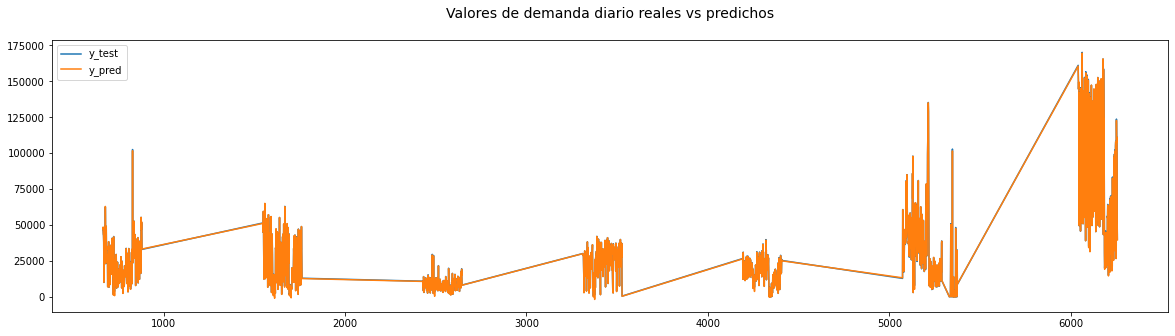

In [55]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(20,5))
plt.title('Valores de demanda diario reales vs predichos\n', fontsize=14)
plt.show()

In [56]:
# Probemos con otros features: eliminamos los features de nula y menor correlación con el target
coef_corr = data_period.corr()['cantidad'].abs().reset_index()
drop_cols = coef_corr[(coef_corr['cantidad'] < 0.1) | (coef_corr['cantidad'].isnull())]['index']
data_X = data_X.drop(columns=drop_cols)
X = data_X
X_train, X_test, y_train, y_test, y_pred = train_test_model(X, y)

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.997828
MSE       2.82816e+06
MAE     238.504
EVS       1
MAD      95
ME    67351
====  ===============

Metricas de test del modelo:
====  ============
..           valor
====  ============
R^2       0.999928
MSE   80563
MAE     195
EVS       1
MAD     115
ME     1767
====  ============


In [57]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe()

y_test         y_pred         diff        % var
count    1565.000000    1565.000000  1565.000000  1565.000000
mean    32987.722656   33018.928967   -31.205466          NaN
std     33547.906250   33546.766605   282.205294          NaN
min         0.000000    -123.242226  -889.836529         -inf
25%     11969.804688   12084.732515  -178.528397    -0.718292
50%     23632.394531   23639.370967   -25.178994    -0.111148
75%     37964.570312   38029.273591    77.312182     0.438130
max    170070.343750  169562.130798  1767.471583          inf

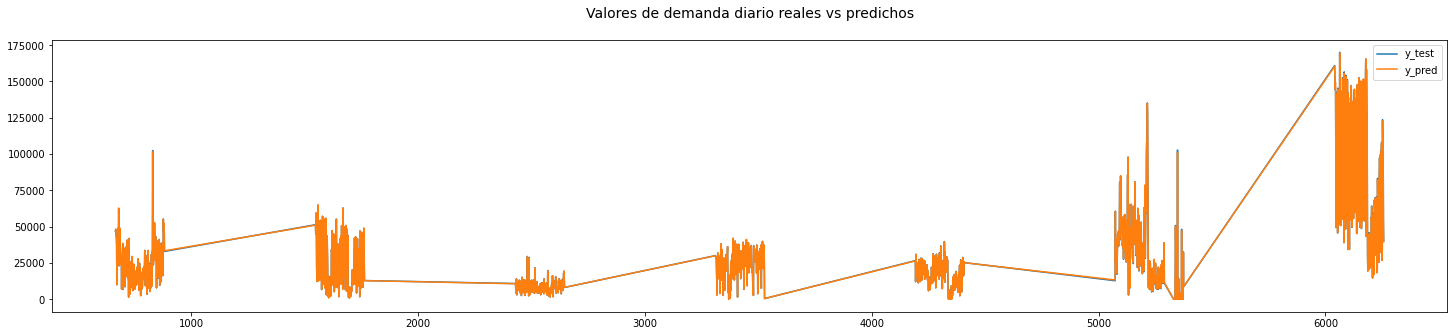

In [58]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(25,5))
plt.title('Valores de demanda diario reales vs predichos\n', fontsize=14)
plt.show()

In [59]:
# Eliminamos algunas de las variables que correlacionan con otra, con menor correlación con la variable target
X = data_X.drop(columns=['lag_1', 'lag_3'])
X_train, X_test, y_train, y_test, y_pred = train_test_model(X, y)

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.943895
MSE       7.30629e+07
MAE    5269.15
EVS       1
MAD    2866
ME    83261
====  ===============

Metricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.943108
MSE       6.39889e+07
MAE    5300
EVS       1
MAD    3550
ME    56081
====  ===============


In [60]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe()

y_test         y_pred          diff        % var
count    1565.000000    1565.000000   1565.000000  1565.000000
mean    32987.722656   33603.733456   -616.009955          NaN
std     33547.906250   33242.988698   7978.101104          NaN
min         0.000000   -5965.249589 -41414.786316         -inf
25%     11969.804688   11906.975528  -4579.299648   -17.985633
50%     23632.394531   24246.731932   -647.847722    -2.846777
75%     37964.570312   41218.879178   2459.825787    13.975550
max    170070.343750  167328.686981  56081.193832          inf

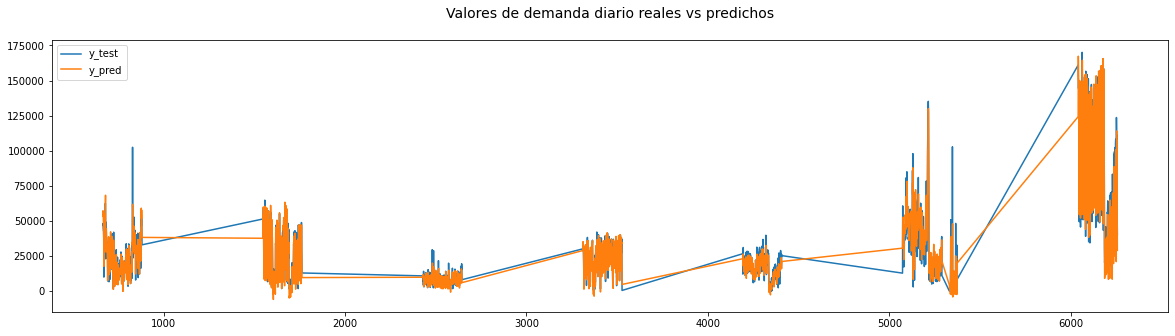

In [61]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(20,5))
plt.title('Valores de demanda diario reales vs predichos\n', fontsize=14)
plt.show()

In [62]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe()

y_test         y_pred          diff        % var
count    1565.000000    1565.000000   1565.000000  1565.000000
mean    32987.722656   33603.733456   -616.009955          NaN
std     33547.906250   33242.988698   7978.101104          NaN
min         0.000000   -5965.249589 -41414.786316         -inf
25%     11969.804688   11906.975528  -4579.299648   -17.985633
50%     23632.394531   24246.731932   -647.847722    -2.846777
75%     37964.570312   41218.879178   2459.825787    13.975550
max    170070.343750  167328.686981  56081.193832          inf

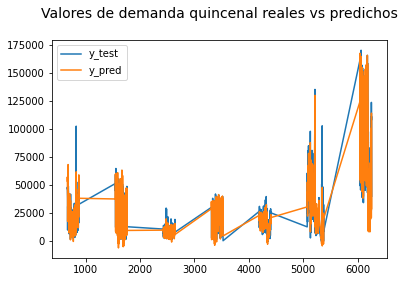

In [63]:
pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot()
plt.title('Valores de demanda quincenal reales vs predichos\n', fontsize=14)
plt.show()

# Nuevas pruebas de entrenamiento

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.997902
MSE       2.73222e+06
MAE     253.339
EVS       1
MAD      86
ME    65404
====  ===============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.999873
MSE   142589
MAE      205
EVS        1
MAD      111
ME      3295
====  =============
Resultados de error
              y_test         y_pred         diff        % var
count    1565.000000    1565.000000  1565.000000  1565.000000
mean    32987.722656   33021.761990   -34.038489          NaN
std     33547.906250   33556.124203   376.192138          NaN
min         0.000000   -1753.323579  -868.677508         -inf
25%     11969.804688   12047.645735  -176.947181    -0.858384
50%     23632.394531   23651.195791   -48.293181    -0.238568
75%     37964.570312   38006.065847    40.341943     0.180871
max    170070.343750  169618.228343  3295.063579          inf


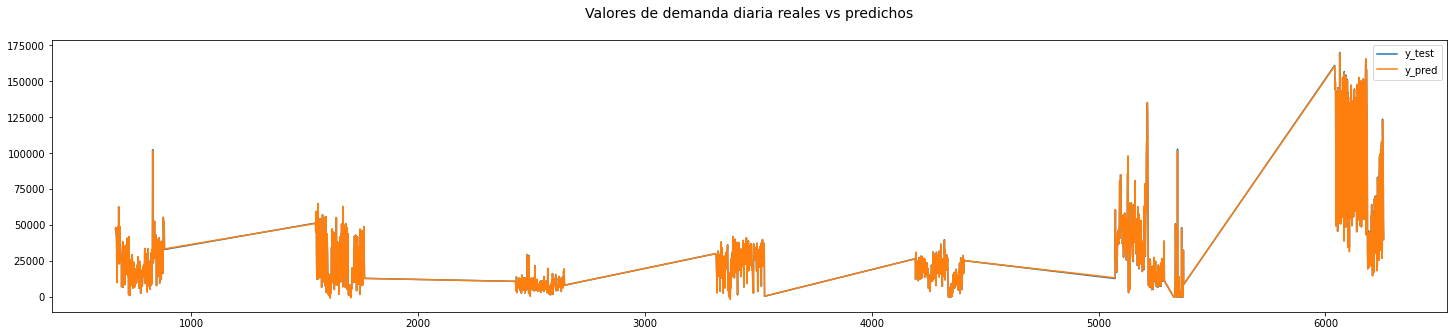

In [64]:
data_X = df_train.drop(columns=['cantidad', 'fecha_hora'])
y = df_train['cantidad']
X = data_X.drop(columns=[
    'year','weekofyear','month','dayofyear','quarter','pct_change_week',
    'day','is_month_end','pct_change'
])
X_train, X_test, y_train, y_test, y_pred = train_test_model(X, y)

print("Resultados de error")
print(pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe())

pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(25,5))
plt.title('Valores de demanda diaria reales vs predichos\n', fontsize=14)
plt.show()

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.997902
MSE       2.73222e+06
MAE     253.339
EVS       1
MAD      86
ME    65404
====  ===============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.999873
MSE   142589
MAE      205
EVS        1
MAD      111
ME      3295
====  =============
Resultados de error
              y_test         y_pred         diff        % var
count    1565.000000    1565.000000  1565.000000  1565.000000
mean    32987.722656   33021.761990   -34.038489          NaN
std     33547.906250   33556.124203   376.192138          NaN
min         0.000000   -1753.323579  -868.677508         -inf
25%     11969.804688   12047.645735  -176.947181    -0.858384
50%     23632.394531   23651.195791   -48.293181    -0.238568
75%     37964.570312   38006.065847    40.341943     0.180871
max    170070.343750  169618.228343  3295.063579          inf


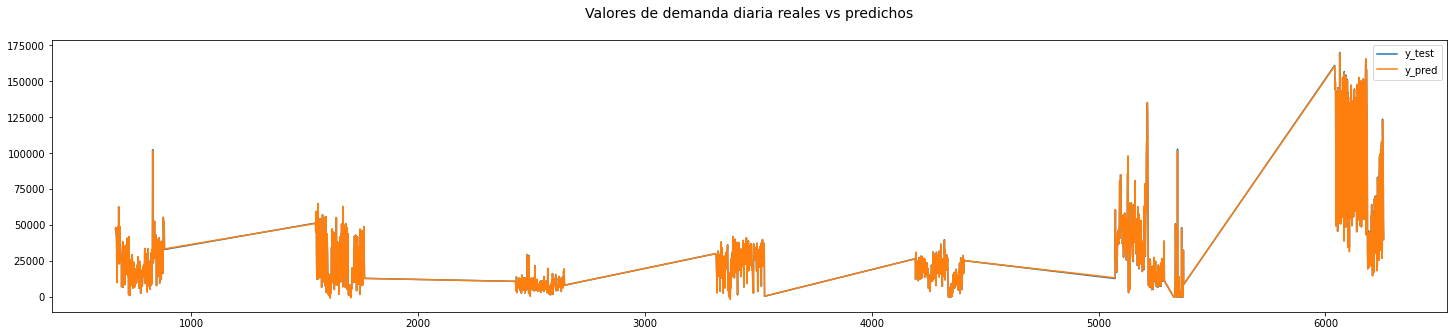

In [65]:
data_X = df_train.drop(columns=['cantidad', 'fecha_hora'])
y = df_train['cantidad']
X = data_X.drop(columns=[
    'year','weekofyear','month','dayofyear','quarter','pct_change_week',
    'day','is_month_end','pct_change'
])
X_train, X_test, y_train, y_test, y_pred = train_test_model(X, y)

print("Resultados de error")
print(pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe())

pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(25,5))
plt.title('Valores de demanda diaria reales vs predichos\n', fontsize=14)
plt.show()

El mejor modelo parece ser el ultimo expuesto dado su R^2. con las columnas ['cantidad_vehiculos', 'year', 'month', 'weekofyear', 'weekday',
       'quarter', 'is_quarter_start', 'is_quarter_end', 'day', 'dayofyear',
       'is_month_start', 'is_month_end', 'sma3', 'sma6', 'pct_change',
       'pct_change_week', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6',
       'lag_7', 'cantidad_vehiculos_lag_7', 'segmento_Agro',
       'segmento_Constructoras', 'segmento_Estaciones_de_Servicio',
       'segmento_Industria', 'segmento_Mineria', 'segmento_Oil_and_Gas',
       'segmento_Telcos', 'segmento_Transporte']
El problema es que estamos haciendo mal la particion del dataset. como es una serie temporal no podemos romper esa temporalidad, debemos validar los resultados usando TimeSeriesSplit

Metricas de train del modelo:
====  ============
..           valor
====  ============
R^2        0.99649
MSE   794415
MAE      217
EVS        1
MAD      102
ME     16684
====  ============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.999648
MSE   169556
MAE      219
EVS        1
MAD      126
ME      4319
====  =============
Resultados de error
              y_test         y_pred         diff        % var
count    1043.000000    1043.000000  1043.000000  1043.000000
mean    27348.410156   27320.848919    27.561350     1.087845
std     21962.562500   21881.489710   411.045761    26.851166
min       145.061996   -2246.888081 -1030.214543   -48.734503
25%      7517.391357    7492.618790  -143.838395    -0.812030
50%     25240.357422   25503.729511   -13.428617    -0.091205
75%     43442.923828   43248.762367    92.455500     0.505142
max    153575.156250  151463.019318  4319.020371   803.086285


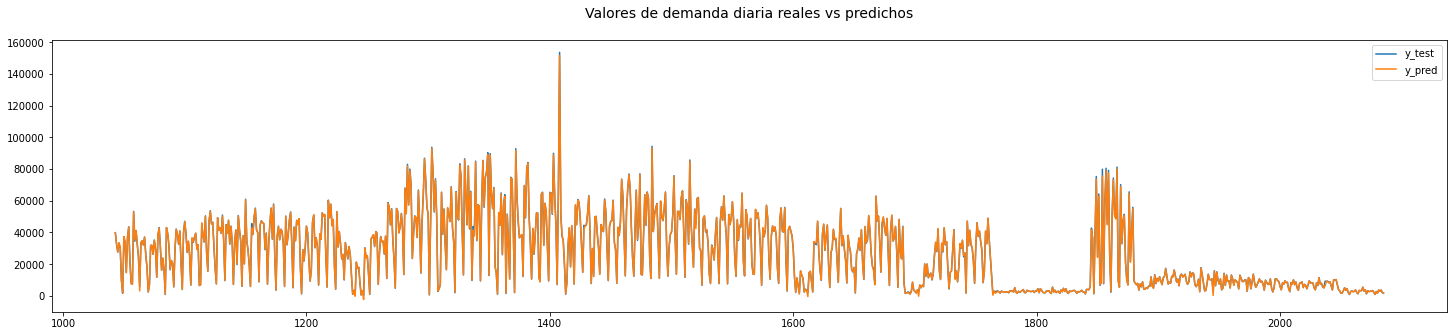

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.998804
MSE   429580
MAE      100
EVS        1
MAD       40
ME     18127
====  =============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.993637
MSE   101720
MAE       76
EVS        1
MAD       42
ME      7377
====  =============
Resultados de error
             y_test        y_pred         diff         % var
count   1043.000000   1043.000000  1043.000000   1043.000000
mean    8035.850586   8063.481249   -27.630378    -10.390903
std     4000.054199   4003.973840   317.889123    373.711073
min        5.749000  -1339.214386 -7376.629752 -11788.461305
25%     5386.629883   5406.695942   -61.190355     -1.021762
50%     7724.109863   7749.332580   -40.309159     -0.570822
75%    10977.770020  11013.479479   -11.883536     -0.128295
max    29519.109375  29430.733797  3617.793090   2368.778188


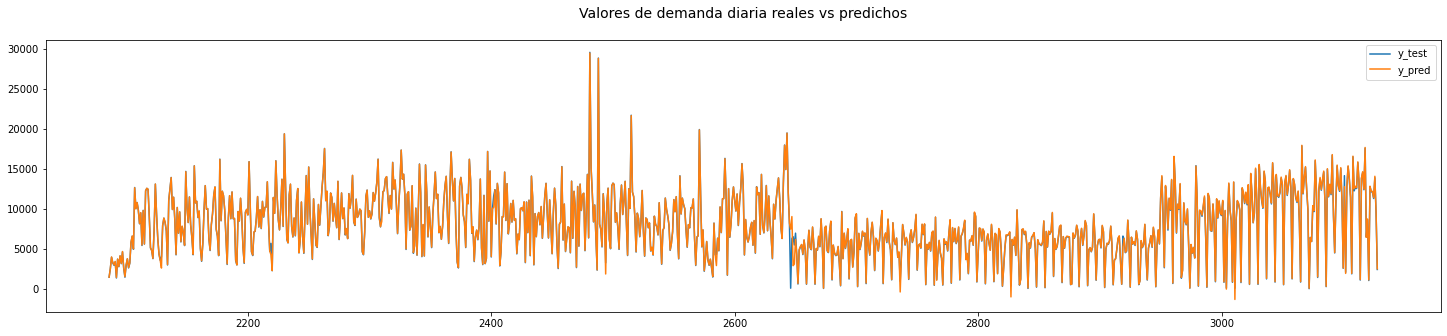

Metricas de train del modelo:
====  ============
..           valor
====  ============
R^2        0.99897
MSE   318989
MAE       83
EVS        1
MAD       31
ME     18111
====  ============

Metricas de test del modelo:
====  ===========
..          valor
====  ===========
R^2       0.99964
MSE   35908
MAE      53
EVS       1
MAD      24
ME     2240
====  ===========
Resultados de error
             y_test        y_pred         diff        % var
count   1043.000000   1043.000000  1043.000000  1043.000000
mean   14505.866211  14486.570228    19.294360          NaN
std     9996.710938   9980.717818   188.599513          NaN
min        0.000000  -1167.059893 -2239.623355         -inf
25%     6641.250977   6643.901526   -11.746886    -0.138484
50%    12664.536133  12648.833421     8.273428     0.074556
75%    21625.200195  21571.388825    35.832736     0.214585
max    42069.308594  41960.526067  2173.732929          inf


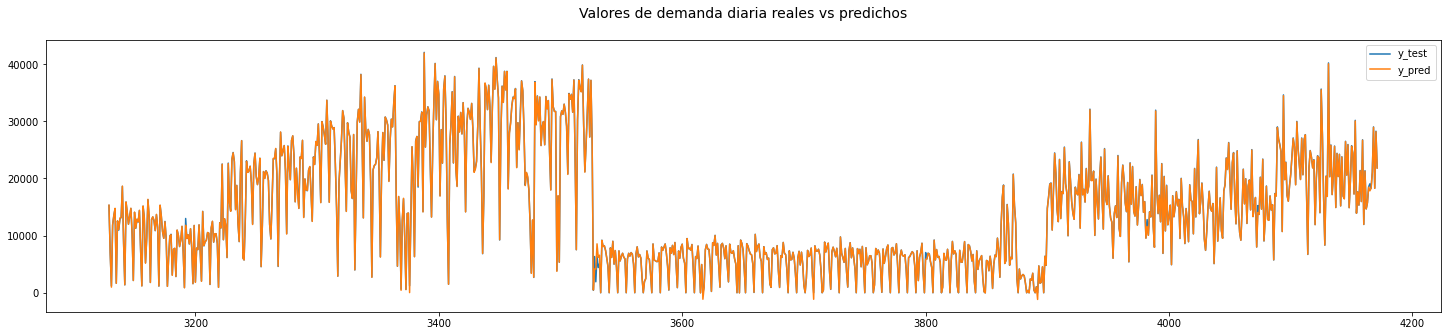

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.999055
MSE   247218
MAE       67
EVS        1
MAD       23
ME     18435
====  =============

Metricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.995271
MSE       6.24264e+06
MAE     254
EVS       1
MAD      63
ME    51461
====  ===============
Resultados de error
              y_test         y_pred          diff        % var
count    1043.000000    1043.000000   1043.000000  1043.000000
mean    54029.925781   53893.136707    136.788027         -inf
std     36350.203125   36247.365840   2495.977616          NaN
min         0.000000      31.872565 -41732.761052         -inf
25%     24103.376953   24171.897096    -19.705169    -0.055330
50%     47738.140625   47628.617131     31.994618     0.091236
75%     73585.234375   73326.355089    122.432182     0.190056
max    193830.125000  193012.691447  51460.634655    81.986253


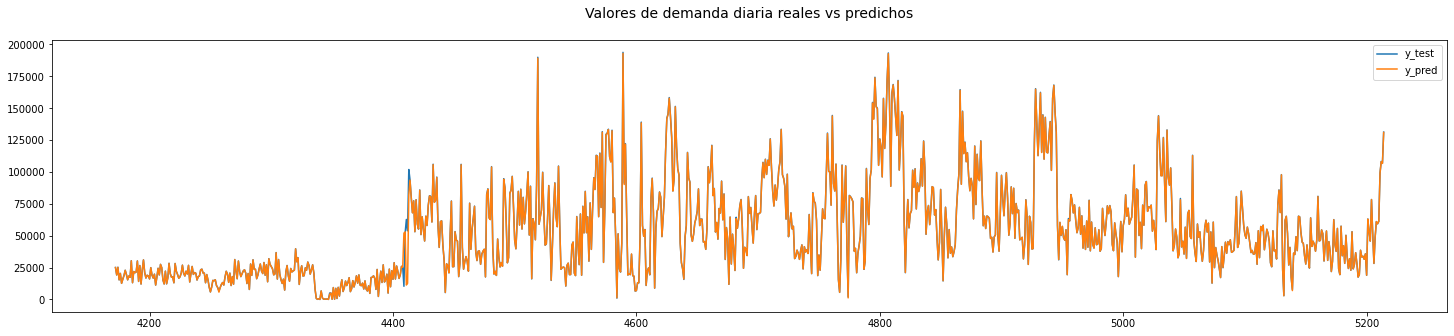

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.998057
MSE       1.31912e+06
MAE     128
EVS       1
MAD      37
ME    52850
====  ===============

Metricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.996791
MSE       6.04956e+06
MAE     333
EVS       1
MAD     181
ME    70524
====  ===============
Resultados de error
              y_test         y_pred          diff        % var
count    1043.000000    1043.000000   1043.000000  1043.000000
mean    77562.484375   77691.488721   -129.006024          NaN
std     43438.054688   43425.811871   2457.377106          NaN
min         0.000000     -84.213268 -70524.421907         -inf
25%     48232.984375   48324.835544   -231.101626    -0.416052
50%     75714.820312   75977.626981   -152.598522    -0.208714
75%    116132.906250  116371.843501    -33.161593    -0.060107
max    170070.343750  169721.612492  28471.083015          inf

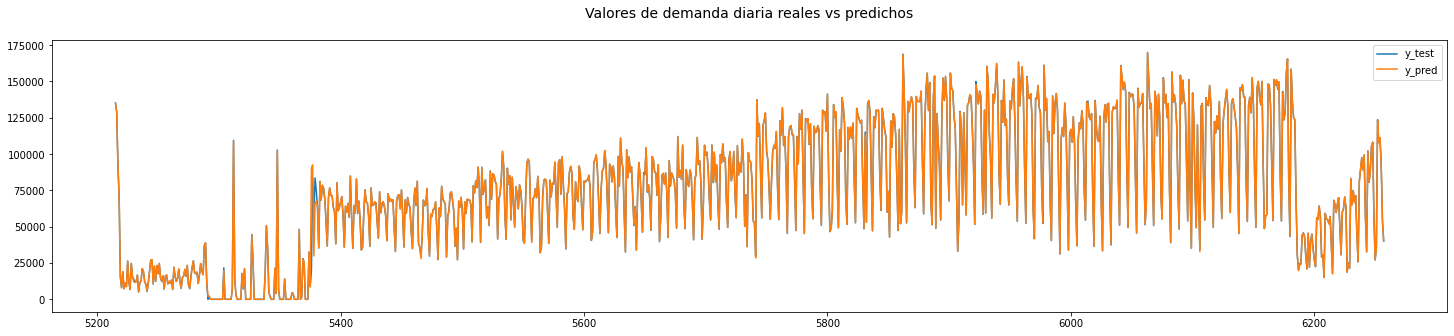

R^2 train promedio:0.9982751270620314
R^2 test promedio:0.9969973621959477


In [66]:
# Cross validator para time series
from sklearn.model_selection import TimeSeriesSplit

# Intentemos obtener un modelo con los siguientes features
data_X = X#df_train.drop(columns=['cantidad', 'fecha_hora'])
y = df_train['cantidad']

X = data_X

tscv = TimeSeriesSplit()
r_cuadrados_train = []
r_cuadrados_test = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model_LR = LinearRegression()
    model_LR.fit(X_train, y_train)
    y_pred_train = model_LR.predict(X_train)
    y_pred = model_LR.predict(X_test)
    r_cuadrados_train.append(r2_score(y_train, y_pred_train))
    r_cuadrados_test.append(r2_score(y_test, y_pred))
    metricas_train = {'R^2': r2_score(y_train, y_pred_train), 'MSE': round(mean_squared_error(y_train, y_pred_train)), 
                     'MAE': round(mean_absolute_error(y_train, y_pred_train)), 'EVS': round(explained_variance_score(y_train, y_pred_train)), 
                     'MAD': round(median_absolute_error(y_train, y_pred_train)), 'ME': round(max_error(y_train, y_pred_train))}
    metricas_test = {'R^2': r2_score(y_test, y_pred), 'MSE': round(mean_squared_error(y_test, y_pred)), 
                     'MAE': round(mean_absolute_error(y_test, y_pred)), 'EVS': round(explained_variance_score(y_test, y_pred)), 
                     'MAD': round(median_absolute_error(y_test, y_pred)), 'ME': round(max_error(y_test, y_pred))}
    print(f'Metricas de train del modelo:')
    print(pd.Series(metricas_train, name='valor').to_markdown(tablefmt="rst"))   # Requiere instalar tabulate
    print(f'\nMetricas de test del modelo:')
    print(pd.Series(metricas_test, name='valor').to_markdown(tablefmt="rst")) 
    print("Resultados de error")
    print(pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe())

    pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(25,5))
    plt.title('Valores de demanda diaria reales vs predichos\n', fontsize=14)
    plt.show()
    
print("R^2 train promedio:{}".format(sum(r_cuadrados_train)/len(r_cuadrados_train)))
print("R^2 test promedio:{}".format(sum(r_cuadrados_test)/len(r_cuadrados_test)))

# Comparacion con SVM

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.995067
MSE       1.11666e+06
MAE     423
EVS       1
MAD     248
ME    17434
====  ===============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.998412
MSE   765444
MAE      611
EVS        1
MAD      403
ME      4593
====  =============
Resultados de error
              y_test         y_pred         diff        % var
count    1043.000000    1043.000000  1043.000000  1043.000000
mean    27348.410156   26858.898356   489.511913     3.800560
std     21962.562500   21712.378547   725.484070    13.556316
min       145.061996   -1092.716589 -1640.391714  -128.810529
25%      7517.391357    7086.189713    71.186497     0.617968
50%     25240.357422   24829.198524   335.331394     2.285312
75%     43442.923828   43176.547702   785.881982     4.247176
max    153575.156250  149409.158683  4592.633557   281.023941


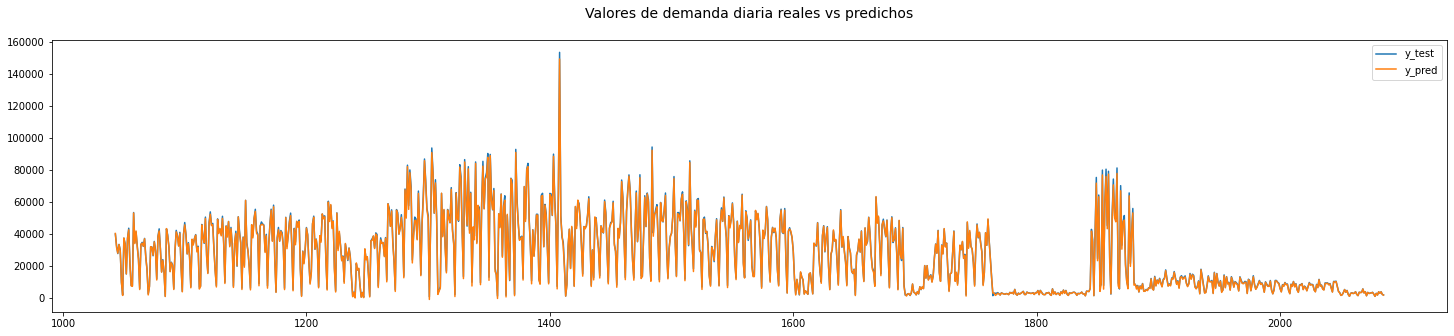

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.997661
MSE   839704
MAE      500
EVS        1
MAD      376
ME     16898
====  =============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.988759
MSE   179693
MAE      263
EVS        1
MAD      208
ME      7104
====  =============
Resultados de error
             y_test        y_pred         diff         % var
count   1043.000000   1043.000000  1043.000000   1043.000000
mean    8035.850586   8189.902422  -154.051551    -23.201635
std     4000.054199   3941.240901   395.108966    390.781107
min        5.749000    202.999421 -7104.042652 -11352.844690
25%     5386.629883   5593.104036  -332.619538     -5.662791
50%     7724.109863   7815.701209  -144.558131     -2.831967
75%    10977.770020  11066.368600    47.081020      0.519201
max    29519.109375  28570.984451  4704.930722     72.418665


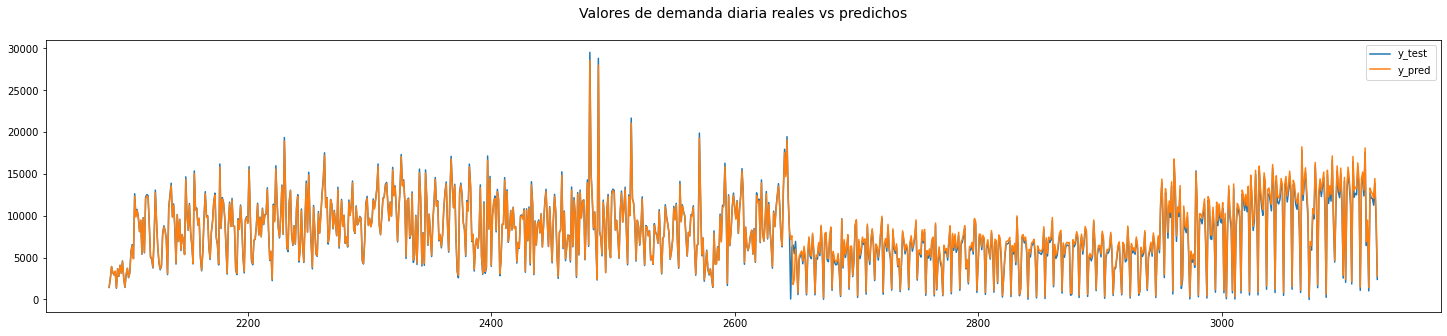

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.995975
MSE       1.24629e+06
MAE     635
EVS       1
MAD     360
ME    19025
====  ===============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.996915
MSE   308037
MAE      398
EVS        1
MAD      285
ME      3595
====  =============
Resultados de error
             y_test        y_pred         diff        % var
count   1043.000000   1043.000000  1043.000000  1043.000000
mean   14505.866211  14606.559035  -100.694447          NaN
std     9996.710938   9856.503489   546.062204          NaN
min        0.000000    -18.978892 -3594.874737         -inf
25%     6641.250977   6688.188465  -373.734868    -4.309002
50%    12664.536133  12971.290245   -82.366339    -0.639300
75%    21625.200195  21581.608493   210.000223     1.519099
max    42069.308594  40542.411796  2208.564387          inf


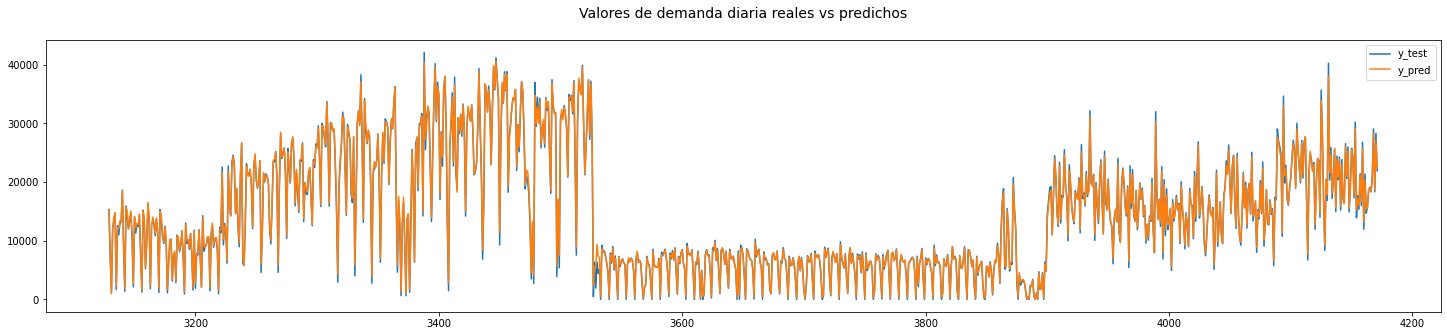

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.976203
MSE       6.22803e+06
MAE    1558
EVS       1
MAD     933
ME    28518
====  ===============

Metricas de test del modelo:
====  ==============
..             valor
====  ==============
R^2       0.961536
MSE       5.0775e+07
MAE    4160
EVS       1
MAD    2515
ME    96452
====  ==============
Resultados de error
              y_test         y_pred          diff        % var
count    1043.000000    1043.000000   1043.000000  1043.000000
mean    54029.925781   53593.223293    436.701440         -inf
std     36350.203125   34268.401177   7115.678477          NaN
min         0.000000  -33684.171053 -24100.310472         -inf
25%     24103.376953   25411.377248  -2462.037714    -7.176400
50%     47738.140625   48308.698913    -56.104852    -0.133133
75%     73585.234375   72082.772701   2569.024028     4.995098
max    193830.125000  180890.009531  96451.565584   175.321254


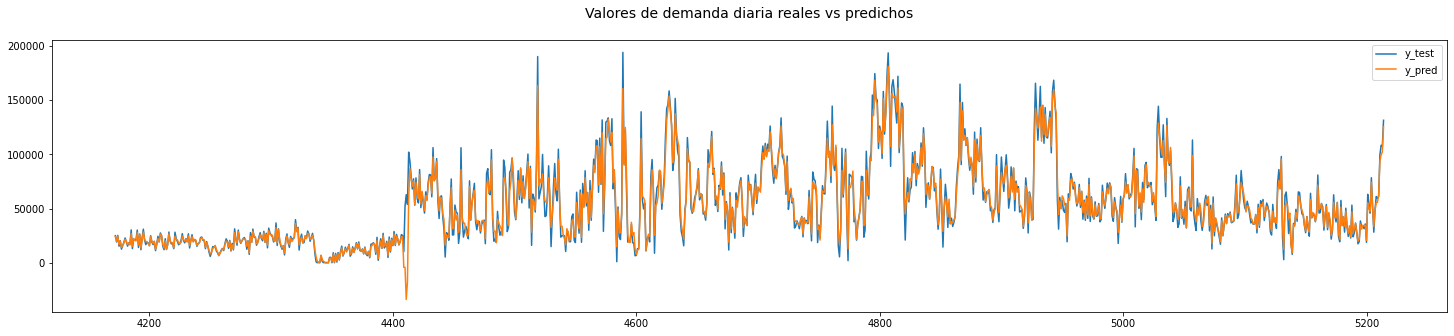

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.98802
MSE       8.13234e+06
MAE    1395
EVS       1
MAD     682
ME    81087
====  ===============

Metricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.987148
MSE       2.42258e+07
MAE    3517
EVS       1
MAD    3181
ME    58572
====  ===============
Resultados de error
              y_test         y_pred          diff        % var
count    1043.000000    1043.000000   1043.000000  1043.000000
mean    77562.484375   74528.513725   3033.968972          NaN
std     43438.054688   41184.955975   3877.537145          NaN
min         0.000000   -1854.694220 -33184.524066         -inf
25%     48232.984375   47269.455063    791.118646     2.100273
50%     75714.820312   72249.096410   3061.910818     3.938480
75%    116132.906250  112060.486923   4822.452442     5.009940
max    170070.343750  161501.461855  58571.765120          inf


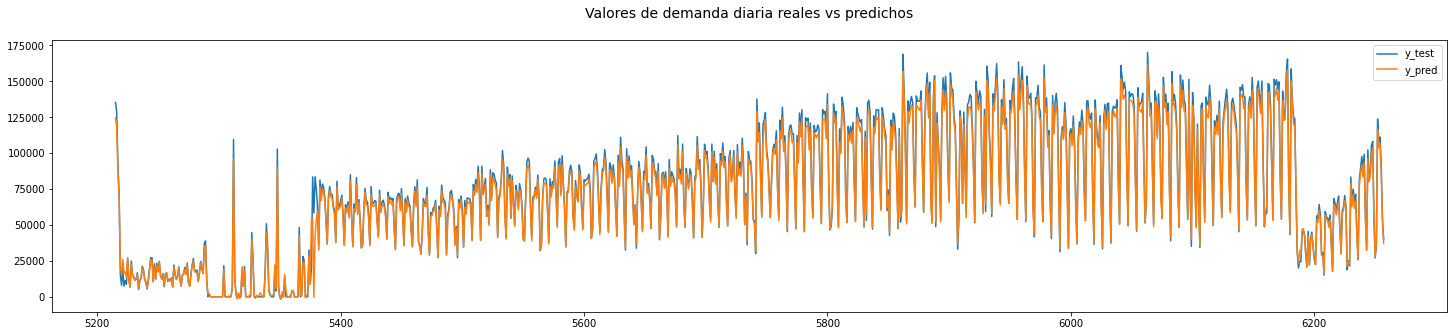

R^2 train promedio:0.9905851094154908
R^2 test promedio:0.9865538994435085


In [76]:
# Cross validator para time series
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Intentemos obtener un modelo con los siguientes features
data_X = X#df_train.drop(columns=['cantidad', 'fecha_hora'])
y = df_train['cantidad']

X = data_X

tscv = TimeSeriesSplit()
r_cuadrados_train = []
r_cuadrados_test = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model_LR = svm.LinearSVR()
    model_LR.fit(X_train, y_train)
    y_pred_train = model_LR.predict(X_train)
    y_pred = model_LR.predict(X_test)
    r_cuadrados_train.append(r2_score(y_train, y_pred_train))
    r_cuadrados_test.append(r2_score(y_test, y_pred))
    metricas_train = {'R^2': r2_score(y_train, y_pred_train), 'MSE': round(mean_squared_error(y_train, y_pred_train)), 
                     'MAE': round(mean_absolute_error(y_train, y_pred_train)), 'EVS': round(explained_variance_score(y_train, y_pred_train)), 
                     'MAD': round(median_absolute_error(y_train, y_pred_train)), 'ME': round(max_error(y_train, y_pred_train))}
    metricas_test = {'R^2': r2_score(y_test, y_pred), 'MSE': round(mean_squared_error(y_test, y_pred)), 
                     'MAE': round(mean_absolute_error(y_test, y_pred)), 'EVS': round(explained_variance_score(y_test, y_pred)), 
                     'MAD': round(median_absolute_error(y_test, y_pred)), 'ME': round(max_error(y_test, y_pred))}
    print(f'Metricas de train del modelo:')
    print(pd.Series(metricas_train, name='valor').to_markdown(tablefmt="rst"))   # Requiere instalar tabulate
    print(f'\nMetricas de test del modelo:')
    print(pd.Series(metricas_test, name='valor').to_markdown(tablefmt="rst")) 
    print("Resultados de error")
    print(pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe())

    pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(25,5))
    plt.title('Valores de demanda diaria reales vs predichos\n', fontsize=14)
    plt.show()
    
print("R^2 train promedio:{}".format(sum(r_cuadrados_train)/len(r_cuadrados_train)))
print("R^2 test promedio:{}".format(sum(r_cuadrados_test)/len(r_cuadrados_test)))

# GridSearch

In [103]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import os
param_grid = {
    "normalize": [True,False],
    "fit_intercept": [True,False]
}
lr_cv = GridSearchCV(estimator=LinearRegression(),param_grid=param_grid, scoring=make_scorer(r2_score), cv=tscv.split(X), n_jobs=os.cpu_count())
lr_cv.fit(X,y)
print('best score. r^2= {}'.format(lr_cv.best_score_))
print('best_parameters: {}'.format(lr_cv.best_params_))

best score. r^2= 0.9992579931295212
best_parameters: {'fit_intercept': False, 'normalize': True}


In [105]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import os
param_grid = {
    "epsilon":[30,40,45,50,55,60,70,80,100],
    "C":[0.2,.4,.6,.8,1],
    "loss": ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    "dual":[True,False]
}
svr_cv = GridSearchCV(estimator=svm.LinearSVR(random_state=0),param_grid=param_grid, scoring=make_scorer(r2_score), cv=tscv.split(X), n_jobs=os.cpu_count())
svr_cv.fit(X,y)
print('best score. r^2= {}'.format(svr_cv.best_score_))
print('best_parameters: {}'.format(svr_cv.best_params_))

best score. r^2= 0.9998265999072589
best_parameters: {'C': 1, 'dual': False, 'epsilon': 30, 'loss': 'squared_epsilon_insensitive'}


LinearSVM parece ser superior a LinearRegresion con los parametros obtenidos en la busqueda de hiperparametros. Asique vamos a ver los resultados obtenidos

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.996009
MSE   903234
MAE      147
EVS        1
MAD       58
ME     19245
====  =============

Metricas de test del modelo:
====  ============
..           valor
====  ============
R^2       0.999923
MSE   36916
MAE     121
EVS       1
MAD      67
ME     1866
====  ============
Resultados de error
              y_test         y_pred         diff        % var
count    1043.000000    1043.000000  1043.000000  1043.000000
mean    27348.410156   27356.098082    -7.687813    -0.464061
std     21962.562500   21902.756974   192.073419     5.335969
min       145.061996     134.423830 -1866.137141  -146.537020
25%      7517.391357    7557.363506   -92.165981    -0.475840
50%     25240.357422   25313.051148   -12.849781    -0.097042
75%     43442.923828   43289.897006    39.008173     0.203428
max    153575.156250  152830.125320  1089.855853    39.644644


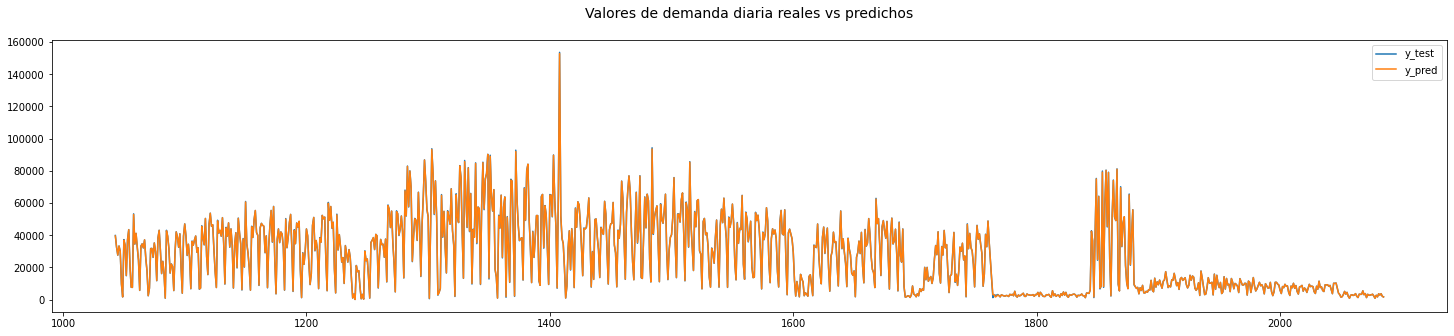

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.998728
MSE   456683
MAE       72
EVS        1
MAD       21
ME     19306
====  =============

Metricas de test del modelo:
====  =============
..            valor
====  =============
R^2        0.993694
MSE   100805
MAE       28
EVS        1
MAD        9
ME      8713
====  =============
Resultados de error
             y_test        y_pred         diff         % var
count   1043.000000   1043.000000  1043.000000   1043.000000
mean    8035.850586   8042.196875    -6.346005    -13.912652
std     4000.054199   3993.367738   317.586219    431.240704
min        5.749000     21.004327 -8713.347686 -13924.646552
25%     5386.629883   5381.986692   -10.809788     -0.154088
50%     7724.109863   7748.903711    -3.870454     -0.050273
75%    10977.770020  10984.501242     4.274907      0.049575
max    29519.109375  29467.387669  3871.181726     59.585535


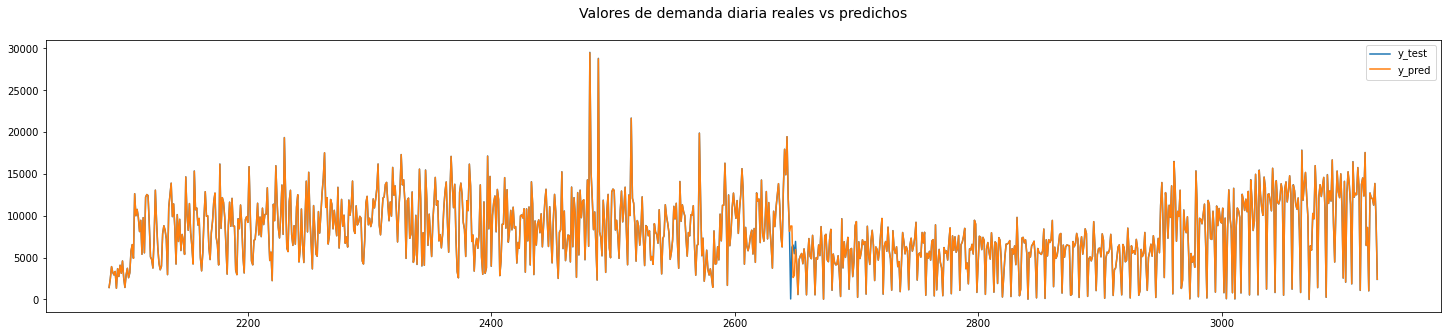

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.998909
MSE   337929
MAE       57
EVS        1
MAD       14
ME     19091
====  =============

Metricas de test del modelo:
====  ============
..           valor
====  ============
R^2       0.999797
MSE   20315
MAE      25
EVS       1
MAD      12
ME     2305
====  ============
Resultados de error
             y_test        y_pred         diff        % var
count   1043.000000   1043.000000  1043.000000  1043.000000
mean   14505.866211  14515.568402    -9.703814          NaN
std     9996.710938   9989.040635   142.268243          NaN
min        0.000000     -6.256909 -2305.077107         -inf
25%     6641.250977   6650.421283   -14.834273    -0.150069
50%    12664.536133  12636.553931    -5.432562    -0.051659
75%    21625.200195  21627.758136     4.898999     0.038590
max    42069.308594  42002.739120  2115.820017          inf


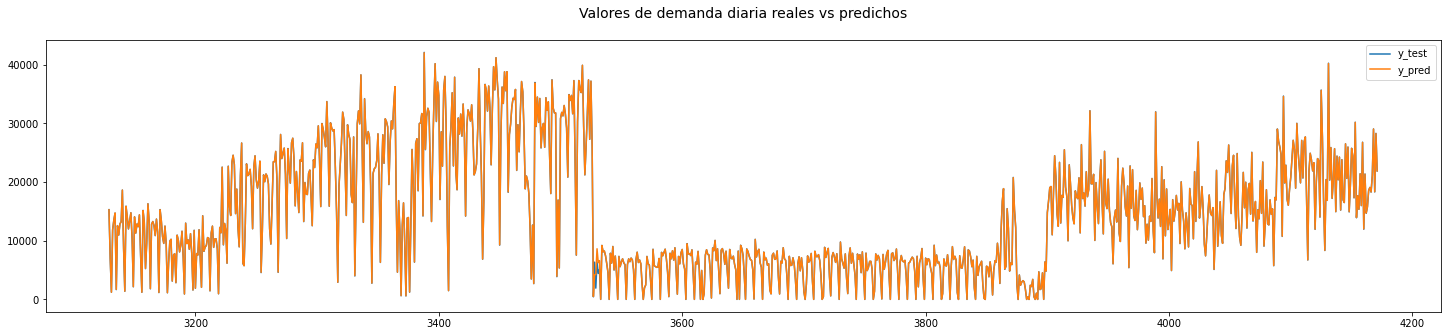

Metricas de train del modelo:
====  =============
..            valor
====  =============
R^2        0.999012
MSE   258613
MAE       46
EVS        1
MAD       12
ME     19218
====  =============

Metricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.995169
MSE       6.37703e+06
MAE     196
EVS       1
MAD      33
ME    52305
====  ===============
Resultados de error
              y_test         y_pred          diff        % var
count    1043.000000    1043.000000   1043.000000  1043.000000
mean    54029.925781   53956.166440     73.758294          inf
std     36350.203125   36346.561774   2525.411587          NaN
min         0.000000     -12.245438 -41885.332052  -406.332948
25%     24103.376953   24083.633278    -26.391226    -0.067783
50%     47738.140625   47490.701447      5.635980     0.013409
75%     73585.234375   73569.651029     37.447201     0.080324
max    193830.125000  193597.245812  52305.176992          inf


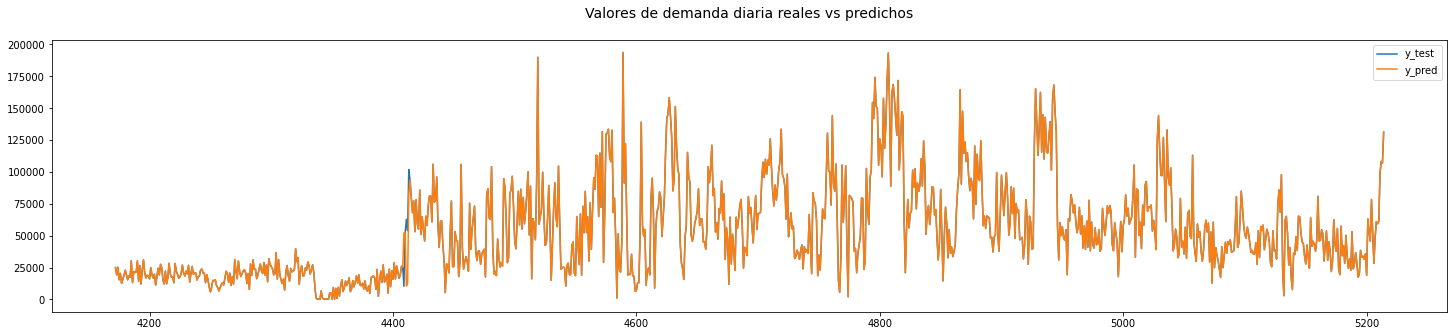

Metricas de train del modelo:
====  ===============
..              valor
====  ===============
R^2       0.998001
MSE       1.35689e+06
MAE     113
EVS       1
MAD      35
ME    53819
====  ===============

Metricas de test del modelo:
====  ===============
..              valor
====  ===============
R^2       0.99669
MSE       6.23914e+06
MAE     289
EVS       1
MAD     115
ME    71684
====  ===============
Resultados de error
              y_test         y_pred          diff        % var
count    1043.000000    1043.000000   1043.000000  1043.000000
mean    77562.484375   77610.569874    -48.087177          NaN
std     43438.054688   43377.002401   2498.562383          NaN
min         0.000000    -157.960436 -71683.840177         -inf
25%     48232.984375   48212.569911   -148.984742    -0.243471
50%     75714.820312   75825.927721    -54.682328    -0.088638
75%    116132.906250  116162.016076     36.497878     0.083268
max    170070.343750  169353.747459  29372.198353          inf


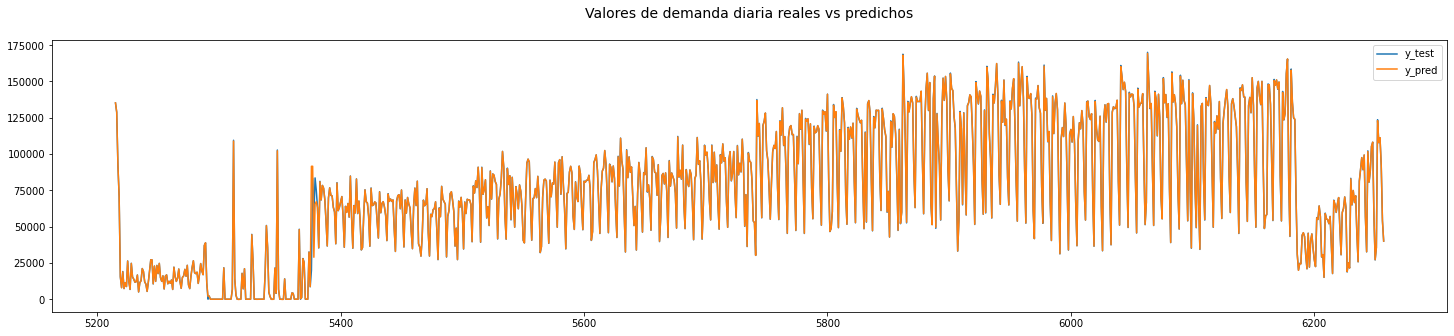

R^2 train promedio:0.9981318042550686
R^2 test promedio:0.9970546272222156


In [107]:
# Cross validator para time series
from sklearn.model_selection import TimeSeriesSplit
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Intentemos obtener un modelo con los siguientes features
data_X = X
y = df_train['cantidad']

X = data_X

tscv = TimeSeriesSplit()
r_cuadrados_train = []
r_cuadrados_test = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    model_LR = svm.LinearSVR(**svr_cv.best_params_,random_state=0)
    model_LR.fit(X_train, y_train)
    y_pred_train = model_LR.predict(X_train)
    y_pred = model_LR.predict(X_test)
    r_cuadrados_train.append(r2_score(y_train, y_pred_train))
    r_cuadrados_test.append(r2_score(y_test, y_pred))
    metricas_train = {'R^2': r2_score(y_train, y_pred_train), 'MSE': round(mean_squared_error(y_train, y_pred_train)), 
                     'MAE': round(mean_absolute_error(y_train, y_pred_train)), 'EVS': round(explained_variance_score(y_train, y_pred_train)), 
                     'MAD': round(median_absolute_error(y_train, y_pred_train)), 'ME': round(max_error(y_train, y_pred_train))}
    metricas_test = {'R^2': r2_score(y_test, y_pred), 'MSE': round(mean_squared_error(y_test, y_pred)), 
                     'MAE': round(mean_absolute_error(y_test, y_pred)), 'EVS': round(explained_variance_score(y_test, y_pred)), 
                     'MAD': round(median_absolute_error(y_test, y_pred)), 'ME': round(max_error(y_test, y_pred))}
    print(f'Metricas de train del modelo:')
    print(pd.Series(metricas_train, name='valor').to_markdown(tablefmt="rst"))   # Requiere instalar tabulate
    print(f'\nMetricas de test del modelo:')
    print(pd.Series(metricas_test, name='valor').to_markdown(tablefmt="rst")) 
    print("Resultados de error")
    print(pd.DataFrame({'y_test': y_test,'y_pred': y_pred, 'diff': y_test - y_pred, '% var': (y_test - y_pred)/y_test*100}).describe())

    pd.DataFrame({'y_test': y_test,'y_pred': y_pred}).sort_index().plot(figsize=(25,5))
    plt.title('Valores de demanda diaria reales vs predichos\n', fontsize=14)
    plt.show()
    
print("R^2 train promedio:{}".format(sum(r_cuadrados_train)/len(r_cuadrados_train)))
print("R^2 test promedio:{}".format(sum(r_cuadrados_test)/len(r_cuadrados_test)))